In [1]:
!wandb login

wandb: Currently logged in as: s-li2022 (sli2024). Use `wandb login --relogin` to force relogin


In [2]:
import os, gc, random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import librosa

from tqdm.notebook import tqdm
from glob import glob

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from torch.cuda.amp import GradScaler, autocast
import torch.nn.functional as F

import timm
from timm.models.vision_transformer import Block
from timm.models.layers import to_2tuple

from transformers import ASTFeatureExtractor

from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score

from time import time

# import custom AudioMAE module
from ManausAudioMAE import *

import wandb

In [3]:
def get_logger(log_file='log.txt'):
    import logging
    import sys
    
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    formatter = logging.Formatter('%(message)s')
    # Logging to file
    file_handler = logging.FileHandler(log_file)
    file_handler.setFormatter(formatter)
    logger.addHandler(file_handler)
    # Logging to console
    ch = logging.StreamHandler(sys.stdout)
    ch.setFormatter(formatter)
    logger.addHandler(ch)
    
    return logger

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
def wandb_init(project_name, run_name, config):
    config_dict = {
        k: v for k, v in config.__dict__.items() if not k.startswith('_') and not callable(v) and k != 'copy'
    }
    run = wandb.init(project=project_name, name=run_name, config=config_dict)
    return run

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.value = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.value = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [4]:
DRIVE_FOLDER = "." #"/content/drive/MyDrive/Colab Notebooks"
KEEP_COLS = ['category_number', 'common_name', 'audio_length', 'type', 'remarks', 'quality', 'scientific_name', 'mp3_link', 'region']

class Config:
    dataset_dir = f"{DRIVE_FOLDER}/Audio_XenoCanto"
    model_name = "Manaus_AudioMAE_CLS_GKFold"
    backbone_name = "./training_logs/ViTMAE_Pretrain_best_0.01.pth"
    # number of classes in the dataset
    n_classes = 728  
    # Audio parameters
    audio_sr = 16000 #Hz
    segment_length = 10  #s
    fft_window = 0.025 #s
    hop_window_length = 0.01 #s
    n_mels = 128
    low_cut = 1000 #Hz
    high_cut = 8000 #Hz
    top_db = 100
    # Training parameters
    batch_size = 16 
    num_workers = 0
    n_splits = 5
    log_dir = f"{DRIVE_FOLDER}/training_logs"
    max_lr = 1e-5
    epochs = 15
    weight_decay = 0.01
    lr_final_div = 1000
    amp = True
    grad_accum_steps = 1
    max_grad_norm = 1e7
    print_epoch_freq = 1
    print_freq = 500
    # model parameters
    n_decoder_layers = 6
    n_decoder_heads = 6
    ff_dim_decoder = 2048
    # seed
    random_seed = 2046
    
    @classmethod
    def copy(cls):
        new_class = type('CustomConfig', (cls,), {k: v for k, v in cls.__dict__.items() if not k.startswith('__') and not callable(v)})
        return new_class
    
config = Config.copy()

if not os.path.exists(config.log_dir):
    os.makedirs(config.log_dir)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {DEVICE}")

seed_everything(config.random_seed)

Device: cuda


In [5]:
df_audio_meta = pd.read_csv(f"{config.dataset_dir}/metadata.csv", nrows=None)
df_audio_meta = df_audio_meta.dropna().reset_index(drop=True)

# Filter out files that do not exist
df_audio_meta['file_exists'] = df_audio_meta['file_name'].apply(lambda x: os.path.exists(f"{config.dataset_dir}/{x}"))
df_audio_meta = df_audio_meta[df_audio_meta['file_exists']].reset_index(drop=True)

# parse scientific names
df_audio_meta['scientific_name'] = df_audio_meta['scientific_name'].apply(lambda x: "_".join(x.split(" ")))

# drop species with less than 2 samples
class_counts = df_audio_meta['scientific_name'].value_counts()
print(f"Number of classes with less than 2 samples: {len(class_counts[class_counts < 2])}")

df_audio_meta = df_audio_meta[df_audio_meta['scientific_name'].isin(class_counts[class_counts > 1].index)].copy().reset_index(drop=True)

# encode scientific names to label ids
label_ids_list = df_audio_meta['scientific_name'].unique().tolist()
label_ids_list.sort()
label_to_id = {label: i for i, label in enumerate(label_ids_list)}
df_audio_meta['species_id'] = df_audio_meta['scientific_name'].map(label_to_id)

# save the label mapping
label_mapping = pd.DataFrame(label_to_id.items(), columns=['scientific_name', 'species_id'])
label_mapping.to_csv(f"{config.log_dir}/{config.model_name}_label_map.csv", index=False)

# drop samples with no labels
df_audio_meta.dropna(subset=['species_id'], inplace=True)
df_audio_meta.reset_index(drop=True, inplace=True)
df_audio_meta['species_id'] = df_audio_meta['species_id'].astype(int)

print(f"Number of classes in dataset: {df_audio_meta['species_id'].nunique()}")
print(f'Number of samples:', len(df_audio_meta))

# save the number of classes in the config
config.n_classes = df_audio_meta['species_id'].nunique()

# encode mp3 links to group ids for 5-folds
group_ids = df_audio_meta['mp3_link'].unique().tolist()
group_ids_map = {group_id: i for i, group_id in enumerate(group_ids)}
df_audio_meta['group_id'] = df_audio_meta['mp3_link'].map(group_ids_map)

df_audio_meta.to_csv(f"{config.log_dir}/{config.model_name}_metadata.csv", index=False)

df_audio_meta.head(5)

Number of classes with less than 2 samples: 72
Number of classes in dataset: 728
Number of samples: 11171


,file_name,category_number,common_name,audio_length,type,remarks,quality,mp3_link,scientific_name,region,file_exists,species_id,group_id
0,data/XC228210-Blue-crowned_Manakin_B_9369_0.wav,XC228210,Blue-crowned Manakin,0:20,call,ID certainty 80%. (Archiv. tape 393 side A tra...,B,//xeno-canto.org/sounds/uploaded/OOECIWCSWV/XC...,Lepidothrix_coronata,amazonas,True,329,0
1,data/XC228210-Blue-crowned_Manakin_B_9369_1.wav,XC228210,Blue-crowned Manakin,0:20,call,ID certainty 80%. (Archiv. tape 393 side A tra...,B,//xeno-canto.org/sounds/uploaded/OOECIWCSWV/XC...,Lepidothrix_coronata,amazonas,True,329,0
2,data/XC200163-PIPCOR03_0.wav,XC200163,Blue-crowned Manakin,0:42,"call, song","left bank of rio Negro - terra firme forest, w...",C,//xeno-canto.org/sounds/uploaded/DGVLLRYDXS/XC...,Lepidothrix_coronata,amazonas,True,329,1
3,data/XC200163-PIPCOR03_1.wav,XC200163,Blue-crowned Manakin,0:42,"call, song","left bank of rio Negro - terra firme forest, w...",C,//xeno-canto.org/sounds/uploaded/DGVLLRYDXS/XC...,Lepidothrix_coronata,amazonas,True,329,1
4,data/XC200163-PIPCOR03_2.wav,XC200163,Blue-crowned Manakin,0:42,"call, song","left bank of rio Negro - terra firme forest, w...",C,//xeno-canto.org/sounds/uploaded/DGVLLRYDXS/XC...,Lepidothrix_coronata,amazonas,True,329,1


In [6]:
# check if all species in greater_manaus are in amazonas
greater_manaus = df_audio_meta[df_audio_meta['region'] == 'greater_manaus']
amazonas = df_audio_meta[df_audio_meta['region'] == 'amazonas']

print('Number of species in greater_manaus:', len(greater_manaus['scientific_name'].unique()))
print('Number of species in amazonas:', len(amazonas['scientific_name'].unique()))

shared_species = [x for x in greater_manaus['scientific_name'].unique().tolist() if x in amazonas['scientific_name'].unique().tolist()]

print('Number of species in both regions:', len(shared_species))

Number of species in greater_manaus: 197
Number of species in amazonas: 724
Number of species in both regions: 193


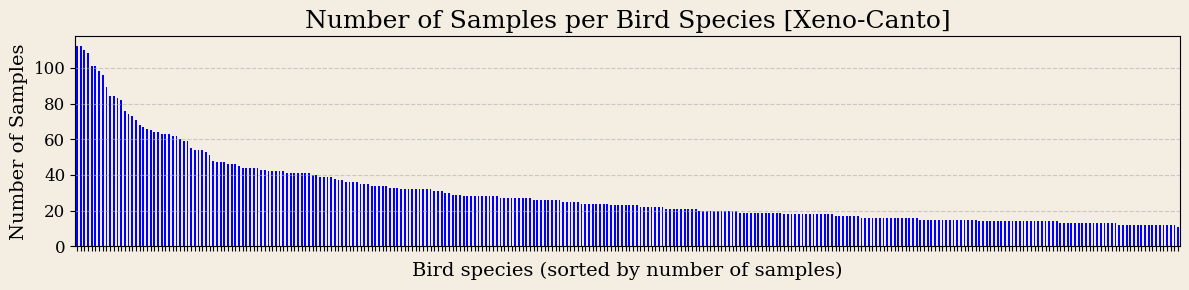

In [7]:
# calculate the number of samples per class and weights for focal loss
class_counts = df_audio_meta['species_id'].value_counts().sort_index()
class_weights = 1 / class_counts

# plot the distribution of the number of samples per class
fig, ax = plt.subplots(figsize=(12, 3))

class_counts_sorted = class_counts.sort_values(ascending=False)
class_counts.sort_values(ascending=False)[0:300].plot(ax=ax, kind='bar', color='blue')
ax.set_xticklabels([])
ax.tick_params(axis='y', labelcolor='black', labelsize=12, labelfontfamily='serif')
ax.set_xlabel('Bird species (sorted by number of samples)', fontsize=14, fontfamily='serif')
ax.set_ylabel('Number of Samples', fontsize=14, fontfamily='serif')
ax.set_title('Number of Samples per Bird Species [Xeno-Canto]', fontsize=18, fontfamily='serif')
ax.set_facecolor('#f3ede2')
fig.set_facecolor('#f3ede2')
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

./Audio_XenoCanto/data/XC424956-Tachyphonus_cristatus_Musa_1133_2.wav


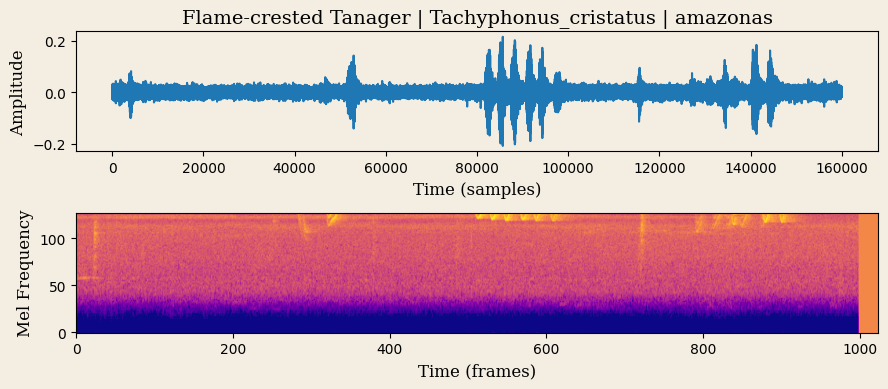

In [8]:
# visualize a sample audio file & spectrogram
sample = df_audio_meta.sample(1)

audio_file = f"{config.dataset_dir}/{sample['file_name'].values[0]}"
print(audio_file)

y, sr = librosa.load(audio_file, sr=config.audio_sr)

meta_str = f"{sample['common_name'].values[0]} | {sample['scientific_name'].values[0]} | {sample['region'].values[0]}"

fig, axes = plt.subplots(2, 1, figsize=(9, 4))

axes[0].plot(y)
axes[0].set_title(meta_str, fontsize=14, fontfamily='serif')
axes[0].set_xlabel('Time (samples)', fontsize=12, fontfamily='serif')
axes[0].set_ylabel('Amplitude', fontsize=12, fontfamily='serif')

mel_spec = ASTFeatureExtractor()(y, sampling_rate=sr, padding="max_length", return_tensors="np")["input_values"]

axes[1].imshow(mel_spec[0].T, aspect='auto', origin='lower', cmap='plasma')
axes[1].set_xlabel('Time (frames)', fontsize=12, fontfamily='serif')
axes[1].set_ylabel('Mel Frequency', fontsize=12, fontfamily='serif')

for ax in axes:
    ax.set_facecolor('#f3ede2')
    
fig.set_facecolor('#f3ede2')
fig.tight_layout()
plt.show()

In [9]:
class BirdSongDataset(Dataset):
    
    def __init__(self, df_audio_meta, config):
        self.df_audio_meta = df_audio_meta
        self.feature_extractor = ASTFeatureExtractor()
        self.config = config
    
    def __len__(self):
        return len(self.df_audio_meta)

    def __getitem__(self, idx):
        row = self.df_audio_meta.iloc[idx]
        audio_path = f"{self.config.dataset_dir}/{row['file_name']}"
        audio_arr, sr = self.get_audio(audio_path)
        spec = self.feature_extractor(audio_arr, sampling_rate=sr, padding="max_length", return_tensors="pt")
        return spec['input_values'].squeeze(0), row['species_id']

    def get_audio(self, audio_path):
        audio, sr = librosa.load(audio_path, sr=self.config.audio_sr)
        return audio, sr

def collate_fn(batch):
    inputs = [x[0] for x in batch]
    targets = [x[1] for x in batch]
    data_dict = {
        "input_ids": torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True, padding_value=0),
        "labels": torch.tensor(targets)
    }
    return data_dict

In [10]:
class SelfAttentionPooling(nn.Module):
    """
    Implementation of SelfAttentionPooling 
    Original Paper: Self-Attention Encoding and Pooling for Speaker Recognition
    https://arxiv.org/pdf/2008.01077v1.pdf
    """
    def __init__(self, input_dim):
        super(SelfAttentionPooling, self).__init__()
        self.W = nn.Linear(input_dim, 1)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, batch_rep):
        """
        input:
            batch_rep : size (N, T, H), N: batch size, T: sequence length, H: Hidden dimension
        attention_weight:
            att_w : size (N, T, 1)
        return:
            utter_rep: size (N, H)
        """
        att_w = self.softmax(self.W(batch_rep).squeeze(-1)).unsqueeze(-1)
        utter_rep = torch.sum(batch_rep * att_w, dim=1)

        return utter_rep


class BirdAudioMAE(nn.Module):
    
    def __init__(self, basename, n_classes, device, n_mlp_layers=1, activation='silu'):
        super(BirdAudioMAE, self).__init__()
        
        # pre-trained backbone
        checkpoint = torch.load(basename, map_location=device)
        self.vit_encoder = ViTEncoder(backbone_name='hf_hub:gaunernst/vit_base_patch16_1024_128.audiomae_as2m', contextual_depth=11)
        self.vit_encoder.load_state_dict({k.replace('enc_model.', ''): v for k, v in checkpoint.items() if 'enc_model' in k})
        
        self.hidden_size = self.vit_encoder.embed_dim
        
        # set activation functions
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'silu':
            self.activation = nn.SiLU()
        elif activation == 'gelu':
            self.activation = nn.GELU()
        else:
            raise ValueError("Unsupported activation function. Choose 'relu', 'silu' or 'gelu'")
        
        # #define self-attention pooling layer
        # self.sa_pool = SelfAttentionPooling(self.hidden_size)
        
        # define MLP layers with activation
        layers = []
        for _ in range(n_mlp_layers):
            layers.append(nn.Linear(self.hidden_size, self.hidden_size))
            layers.append(self.activation)
        layers.append(nn.Linear(self.hidden_size, n_classes))
        self.mlp = nn.Sequential(*layers)
        
        
    def forward(self, spectrogram):
        # spectrogram: (batch_size, n_frames, n_mels)
        # output: (batch_size, n_classes)
        
        encoder_output = self.vit_encoder(spectrogram.unsqueeze(1))
        # pool_output = self.sa_pool(encoder_output)
        logits = self.mlp(encoder_output[:, 0, :])
        
        return {'logits': logits}

In [11]:
# define loss_fn and eval_fn
class FocalLoss(nn.Module):
    
    def __init__(self, gamma=0, alpha=None, reduction='mean', device=DEVICE):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.reduction = reduction
        
        if isinstance(alpha, (float, int, )): 
            self.alpha = torch.Tensor([alpha, 1-alpha])
        elif isinstance(alpha, (list, np.ndarray)): 
            self.alpha = torch.tensor(alpha, dtype=torch.float32, device=device)
        else:
            raise TypeError('Invalid alpha type')
        
        self.ce_loss = nn.CrossEntropyLoss(weight=self.alpha, reduction='none')

    def forward(self, logits, targets):
        ce_loss = self.ce_loss(logits, targets) # nn.CrossEntropyLoss already applies log_softmax
        pt = torch.exp(-ce_loss) # CE = -log(p_t) -> p_t = exp(-CE)
        
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        
        return_method = {
            'mean': torch.mean,
            'sum': torch.sum,
            'none': lambda x: x
        }
        
        return return_method[self.reduction](focal_loss)
        
# eval_fn
class ROC_AUC_Score(nn.Module):
    
    def __init__(self, config, average='macro', multi_class='ovo'):
        super(ROC_AUC_Score, self).__init__()
        self.num_classes = config.n_classes
        self.average = average
        self.multi_class = multi_class  # 'ovo' (one-vs-one) or 'ovr' (one-vs-rest)
        self.label_ids = np.arange(self.num_classes)

    def forward(self, logits, targets):
        # logits: (batch_size, n_classes)
        # targets: (batch_size,) with integer labels
        
        # Apply softmax to convert logits to probabilities
        probas = torch.exp(F.log_softmax(logits, dim=1))

        # Detach and move to CPU for sklearn compatibility
        probas = probas.detach().cpu().numpy()
        targets = targets.detach().cpu().numpy()
        
        df_scores = pd.DataFrame(probas, columns=self.label_ids)
        df_scores['target'] = targets
        
        # remove samples with classes which is predeicted as 0 in all samples
        unscored_cols = df_scores.columns[df_scores.sum(axis=0) == 0]
        rows_to_remove = df_scores['target'].isin(unscored_cols)
        df_scores = df_scores[~rows_to_remove]
        
        eval_score = roc_auc_score(
            y_true=df_scores['target'].values,
            y_score=df_scores[self.label_ids].values,
            average=self.average, 
            multi_class=self.multi_class,
            labels=self.label_ids
        )
        
        return eval_score


In [12]:
# # test the model / loss_fn / eval_fn using dataloader

# bs_dataset = BirdSongDataset(df_audio_meta, config)
# bs_dataloader = DataLoader(bs_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)

# loss_fn = FocalLoss(gamma=2, alpha=class_weights.values, reduction='mean', device='cpu')
# eval_fn = ROC_AUC_Score(config, average='macro', multi_class='ovo')

# model = BirdAudioMAE(config.backbone_name, config.n_classes, device=DEVICE, n_mlp_layers=1, activation='silu')

# for batch in bs_dataloader:
    
#     input_ids = batch['input_ids'] # (batch_size, n_frames, n_mels)s
#     labels = batch['labels']
    
#     output = model(input_ids) # (batch_size, 1, n_frames, n_mels)
#     logits = output['logits']
    
#     loss = loss_fn(logits, labels)
#     eval_score = eval_fn(logits, labels)
    
#     print(f"Shape of input_ids: {input_ids.shape}")
#     print(f"Shape of labels: {labels.shape}")
#     print(f"Shape of logits: {logits.shape}")
#     print(f"Loss: {loss.item()}, Eval Score: {eval_score}")
    
#     break

In [13]:
# # test loss_fn and eval_fn
# loss_fn = FocalLoss(gamma=2, alpha=class_weights.values, reduction='mean', device='cpu')
# eval_fn = ROC_AUC_Score(config, average='macro', multi_class='ovo')

# # target_labels = torch.tensor(df_audio_meta['species_id'].sample(10).values)
# target_labels = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
# print('Target Labels:', target_labels, "\n")

# Test 1: perfect prediction
# logits_perfect = F.one_hot(target_labels, num_classes=config.n_classes).float() * 100
# loss_perfect = loss_fn(logits_perfect, target_labels)

# eval_score_perfect = eval_fn(logits_perfect, target_labels)
# print(f"Perfect Prediction: Loss: {loss_perfect.item()}, Eval Score: {eval_score_perfect}")
# print(" ")

# Test 2: half correct
# half_correct = target_labels.clone()
# half_correct[:5] = (half_correct[:5] + 1) % config.n_classes  
# logits_half = F.one_hot(half_correct, num_classes=config.n_classes).float() * 100
# logits_half[:5] *= -1  
# loss_half = loss_fn(logits_half, target_labels)

# eval_score_half = eval_fn(logits_half, target_labels)
# print(f"Half Correct Prediction: Loss: {loss_half.item()}, Eval Score: {eval_score_half}")
# print(" ")

# Test 3: random prediction
# logits_random = torch.rand((10, config.n_classes))
# loss_random = loss_fn(logits_random, target_labels)

# eval_score_random = eval_fn(logits_random, target_labels)
# print(f"Random Prediction: Loss: {loss_random.item()}, Eval Score: {eval_score_random}")

In [14]:
class Trainer:

    def __init__(self, model, loss_fn, evel_fn, logger, config, is_higher_better=True):
        '''
        model: nn.Module
        loss_fn: loss function
        evel_fn: evaluation function
        logger: logger
        config: Config
        is_higher_better: bool (default: True) whether higher evaluation score is better
        '''

        self.model = model
        self.logger = logger
        self.config = config
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.loss_fn = loss_fn
        self.loss_fn.to(self.device)
        
        self.eval_fn = evel_fn
        self.is_higher_better = is_higher_better
        
    def train(self, train_loader, valid_loader, print_epoch_freq=50, from_checkpoint=None, use_tqdm=True):

        self.optimizer = AdamW(self.model.parameters(), lr=1e-3, weight_decay=self.config.weight_decay)

        self.scheduler = OneCycleLR(
            self.optimizer,
            max_lr=self.config.max_lr,
            epochs=self.config.epochs,
            steps_per_epoch=len(train_loader),
            pct_start=0.1,
            anneal_strategy="cos",
            final_div_factor=self.config.lr_final_div,
        )

        if from_checkpoint is not None:
            self.model.load_state_dict(torch.load(from_checkpoint, map_location=self.device))

        self.model.to(self.device)
        best_weights, best_preds, best_loss = None, None, float("-inf") if self.is_higher_better else float("inf")
        loss_records = {"train": [], "valid": []}
        
        if use_tqdm:
            pbar = tqdm(range(self.config.epochs), total=self.config.epochs, unit="epoch", leave=True, desc="Training Progress")
        else:
            pbar = range(self.config.epochs)
            
        for epoch in pbar:
            start_epoch = time()

            train_loss, _ = self._train_or_valid_epoch(epoch, train_loader, is_train=True, use_tqdm=use_tqdm)
            valid_loss, valid_preds = self._train_or_valid_epoch(epoch, valid_loader, is_train=False, use_tqdm=use_tqdm)
            
            loss_records["train"].append(train_loss)
            loss_records["valid"].append(valid_loss)

            elapsed = time() - start_epoch
            
            if (epoch % print_epoch_freq == 0) or (epoch == (self.config.epochs - 1)):
                self.logger.info(f"Epoch {epoch + 1} - Train Loss: {train_loss:.4f} - Valid Loss: {valid_loss:.4f} - Elapsed Time: {elapsed:.2f}s")
            
            if self.is_higher_better:
                if valid_loss > best_loss:
                    best_loss = valid_loss
                    best_weights = self.model.state_dict()
                    best_preds = valid_preds
                    self.logger.info(f"- Epoch {epoch + 1}: Best model found with loss = {best_loss:.4f}.")
            else:
                if valid_loss < best_loss:
                    best_loss = valid_loss
                    best_weights = self.model.state_dict()
                    best_preds = valid_preds
                    self.logger.info(f"- Epoch {epoch + 1}: Best model found with loss = {best_loss:.4f}.")

        return best_weights, best_preds, loss_records

    def _train_or_valid_epoch(self, epoch_id, dataloader, is_train=True, use_tqdm=True):

        self.model.train() if is_train else self.model.eval()
        mode = "Train" if is_train else "Valid"

        len_loader = len(dataloader)
        scaler = GradScaler(enabled=self.config.amp)
        loss_meter = AverageMeter()
        labels_record, predicts_record = [], []

        start = time()
        
        if use_tqdm:
            pbar = tqdm(enumerate(dataloader), total=len_loader, desc=mode, unit="batch")
        else:
            pbar = enumerate(dataloader)
            
        for step, data_dict in pbar:
            
            input_ids = data_dict['input_ids'].to(self.device)
            labels = data_dict['labels'].to(self.device)
            
            if is_train:
                with autocast(enabled=self.config.amp):
                    model_output = self.model(input_ids)
                    logits = model_output['logits']
                    train_loss = self.loss_fn(logits, labels)
                    
                if self.config.grad_accum_steps > 1:
                    train_loss = train_loss / self.config.grad_accum_steps
                    
                scaler.scale(train_loss).backward()
                grad_norm = torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.config.max_grad_norm)
                if (step + 1) % self.config.grad_accum_steps == 0:
                    scaler.step(self.optimizer)
                    scaler.update()
                    self.optimizer.zero_grad()
                    self.scheduler.step()
                    
                loss_meter.update(train_loss.item())
                
            else:
                with torch.no_grad():
                    model_output = self.model(input_ids)
                    logits = model_output['logits']
                    valid_loss = self.loss_fn(logits, labels)

                if self.config.grad_accum_steps > 1:
                    valid_loss = valid_loss / self.config.grad_accum_steps
                    
                loss_meter.update(valid_loss.item())
                
                predicts_record.append(logits)
                labels_record.append(labels)
            
            end = time()
            
            if self.config.print_freq:
                if (step % self.config.print_freq == 0) or (step == (len_loader - 1)):
                    lr = self.scheduler.get_last_lr()[0]
                    info = f"Epoch {epoch_id + 1} [{step}/{len_loader}] | {mode} "
                    
                    if is_train:
                        info += f"Loss: {loss_meter.avg:.4f} Grad: {grad_norm:.4f} LR: {lr:.4e}"
                    else:
                        info += f"Loss: {loss_meter.avg:.4f}"

                    info += f" | Elapse: {end - start:.2f}s"
                    self.logger.info(info)

        if is_train:
            wandb.log({
                "Train Loss": loss_meter.avg, 
                "Learning Rate": self.scheduler.get_last_lr()[0],
                "Gradient Norm": grad_norm,
                "Epoch": epoch_id + 1
            })
            return loss_meter.avg, None
        else:
            eval_loss = self.eval_fn(
                torch.cat(predicts_record).cpu(),
                torch.cat(labels_record).cpu()
                )
            wandb.log({
                "Valid Loss": loss_meter.avg,
                "Eval Score": eval_loss,
                "Epoch": epoch_id + 1
            })
            predicts_record = np.concatenate([p.cpu().detach().numpy() for p in predicts_record], axis=0)
            return eval_loss, predicts_record


In [15]:
def plot_loss_record(loss_history, final_loss, start_at=0, save_to=None):
    
    fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))
    ax2 = ax1.twinx()
    for i, loss in enumerate(loss_history):
        ax1.plot(np.arange(start_at, len(loss['train'])), loss['train'][start_at:], "-",   label=f'Train_{i}')
        ax2.plot(np.arange(start_at, len(loss['valid'])), loss['valid'][start_at:], ".--", label=f'Valid_{i}')
        
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Train Loss")
    ax2.set_ylabel("Valid Loss (Dashed)")
    ax1.set_title(f"Final Eval-Loss: {final_loss:.4f}")
    ax1.legend(loc='lower left', bbox_to_anchor=[1.15, 0])
    ax2.legend(loc='upper left', bbox_to_anchor=[1.15, 1])
    
    if save_to:
        plt.savefig(save_to)
    
    fig.tight_layout()
    plt.show()

In [16]:
gkf = GroupKFold(n_splits=config.n_splits)
df_audio_meta['fold'] = 0

for fold, (train_index, test_index) in enumerate(gkf.split(df_audio_meta, groups=df_audio_meta['group_id'])):
    df_audio_meta.loc[test_index, 'fold'] = fold
    
display(df_audio_meta['fold'].value_counts())

# check if any sample in valid set has the same mp3_link as the train set
for fold in range(config.n_splits):
    train_group_ids = df_audio_meta[df_audio_meta['fold'] != fold]['mp3_link'].unique()
    valid_group_ids = df_audio_meta[df_audio_meta['fold'] == fold]['mp3_link'].unique()
    common_groups = set(train_group_ids).intersection(set(valid_group_ids))
    print(f"Fold {fold}: Number of common groups between train and valid: {len(common_groups)}")

fold
0    2235
1    2234
4    2234
3    2234
2    2234
Name: count, dtype: int64

Fold 0: Number of common groups between train and valid: 0
Fold 1: Number of common groups between train and valid: 0
Fold 2: Number of common groups between train and valid: 0
Fold 3: Number of common groups between train and valid: 0
Fold 4: Number of common groups between train and valid: 0


In [17]:
loss_fn = FocalLoss(gamma=2, alpha=class_weights.values, reduction='mean', device='cpu')
eval_fn = ROC_AUC_Score(config, average='macro', multi_class='ovo')

oof, loss_history = pd.DataFrame(), []

logger = get_logger(log_file=f"{config.log_dir}/{config.model_name}_training.log")

# log TRAIN_CONFIG
logger.info(f"{'#'*35} TRAIN_CONFIG {'#'*35}")
for k, v in config.__dict__.items():
    if '__' not in k:
        logger.info(f"{k}: {v}")

logger.info(f"{'#'*80}")

################################### TRAIN_CONFIG ###################################
dataset_dir: ./Audio_XenoCanto
model_name: Manaus_AudioMAE_SeqPool_GKFold
backbone_name: ./training_logs/ViTMAE_Pretrain_best_0.01.pth
n_classes: 728
audio_sr: 16000
segment_length: 10
fft_window: 0.025
hop_window_length: 0.01
n_mels: 128
low_cut: 1000
high_cut: 8000
top_db: 100
batch_size: 16
num_workers: 0
n_splits: 5
log_dir: ./training_logs
max_lr: 1e-05
epochs: 15
weight_decay: 0.01
lr_final_div: 1000
amp: True
grad_accum_steps: 1
max_grad_norm: 10000000.0
print_epoch_freq: 1
print_freq: 500
n_decoder_layers: 6
n_decoder_heads: 6
ff_dim_decoder: 2048
random_seed: 2046
copy: <classmethod(<function Config.copy at 0x72147dc2d3f0>)>
################################################################################


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: s-li2022 (sli2024). Use `wandb login --relogin` to force relogin


Loading pretrained weights from Hugging Face hub (gaunernst/vit_base_patch16_1024_128.audiomae_as2m)
Converted input conv patch_embed.proj pretrained weights from 3 to 1 channel(s)


Training Progress:   0%|          | 0/15 [00:00<?, ?epoch/s]

Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 1 [0/559] | Train Loss: 0.7547 Grad: inf LR: 4.0003e-07 | Elapse: 3.92s


/workspace/voice_of_jungle/myenv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1 [500/559] | Train Loss: 0.4139 Grad: 5382.2500 LR: 6.6576e-06 | Elapse: 130.45s
Epoch 1 [558/559] | Train Loss: 0.3826 Grad: 15448.6621 LR: 7.6104e-06 | Elapse: 143.81s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 1 [0/140] | Valid Loss: 0.1736 | Elapse: 0.50s
Epoch 1 [139/140] | Valid Loss: 0.2493 | Elapse: 31.94s
Epoch 1 - Train Loss: 0.3826 - Valid Loss: 0.5310 - Elapsed Time: 194.28s
- Epoch 1: Best model found with loss = 0.5310.


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 2 [0/559] | Train Loss: 0.5166 Grad: inf LR: 7.6259e-06 | Elapse: 0.24s
Epoch 2 [500/559] | Train Loss: 0.2151 Grad: 6359.3657 LR: 9.9786e-06 | Elapse: 126.58s
Epoch 2 [558/559] | Train Loss: 0.2006 Grad: 13655.3486 LR: 9.9660e-06 | Elapse: 139.50s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 2 [0/140] | Valid Loss: 0.1747 | Elapse: 0.22s
Epoch 2 [139/140] | Valid Loss: 0.2309 | Elapse: 31.69s
Epoch 2 - Train Loss: 0.2006 - Valid Loss: 0.5223 - Elapsed Time: 189.41s


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 3 [0/559] | Train Loss: 0.5550 Grad: 509711.9375 LR: 9.9657e-06 | Elapse: 0.25s
Epoch 3 [500/559] | Train Loss: 0.1645 Grad: 12100.7764 LR: 9.7377e-06 | Elapse: 126.85s
Epoch 3 [558/559] | Train Loss: 0.1532 Grad: 23765.9297 LR: 9.6978e-06 | Elapse: 136.91s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 3 [0/140] | Valid Loss: 0.1411 | Elapse: 0.26s
Epoch 3 [139/140] | Valid Loss: 0.2405 | Elapse: 32.07s
Epoch 3 - Train Loss: 0.1532 - Valid Loss: 0.5414 - Elapsed Time: 187.01s
- Epoch 3: Best model found with loss = 0.5414.


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 4 [0/559] | Train Loss: 0.4344 Grad: 504655.3438 LR: 9.6970e-06 | Elapse: 0.27s
Epoch 4 [500/559] | Train Loss: 0.1326 Grad: 12015.6533 LR: 9.2415e-06 | Elapse: 126.02s
Epoch 4 [558/559] | Train Loss: 0.1231 Grad: 19413.2539 LR: 9.1763e-06 | Elapse: 139.71s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 4 [0/140] | Valid Loss: 0.1282 | Elapse: 0.22s
Epoch 4 [139/140] | Valid Loss: 0.2584 | Elapse: 31.84s
Epoch 4 - Train Loss: 0.1231 - Valid Loss: 0.5554 - Elapsed Time: 189.52s
- Epoch 4: Best model found with loss = 0.5554.


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 5 [0/559] | Train Loss: 0.3831 Grad: 562327.7500 LR: 9.1752e-06 | Elapse: 0.24s
Epoch 5 [500/559] | Train Loss: 0.1014 Grad: 11461.7764 LR: 8.5166e-06 | Elapse: 126.26s
Epoch 5 [558/559] | Train Loss: 0.0939 Grad: 17064.9883 LR: 8.4298e-06 | Elapse: 139.79s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 5 [0/140] | Valid Loss: 0.1164 | Elapse: 0.22s
Epoch 5 [139/140] | Valid Loss: 0.2755 | Elapse: 32.11s
Epoch 5 - Train Loss: 0.0939 - Valid Loss: 0.5687 - Elapsed Time: 189.88s
- Epoch 5: Best model found with loss = 0.5687.


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 6 [0/559] | Train Loss: 0.2560 Grad: 641248.6250 LR: 8.4282e-06 | Elapse: 0.25s
Epoch 6 [500/559] | Train Loss: 0.0728 Grad: 10159.9902 LR: 7.6021e-06 | Elapse: 127.05s
Epoch 6 [558/559] | Train Loss: 0.0674 Grad: 14787.0752 LR: 7.4983e-06 | Elapse: 140.69s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 6 [0/140] | Valid Loss: 0.1011 | Elapse: 0.24s
Epoch 6 [139/140] | Valid Loss: 0.2863 | Elapse: 31.57s
Epoch 6 - Train Loss: 0.0674 - Valid Loss: 0.5832 - Elapsed Time: 190.51s
- Epoch 6: Best model found with loss = 0.5832.


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 7 [0/559] | Train Loss: 0.0879 Grad: 530556.9375 LR: 7.4965e-06 | Elapse: 0.25s
Epoch 7 [500/559] | Train Loss: 0.0523 Grad: 4476.6758 LR: 6.5474e-06 | Elapse: 125.62s
Epoch 7 [558/559] | Train Loss: 0.0485 Grad: 5406.0200 LR: 6.4322e-06 | Elapse: 137.98s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 7 [0/140] | Valid Loss: 0.0976 | Elapse: 0.23s
Epoch 7 [139/140] | Valid Loss: 0.2964 | Elapse: 31.59s
Epoch 7 - Train Loss: 0.0485 - Valid Loss: 0.5829 - Elapsed Time: 187.57s


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 8 [0/559] | Train Loss: 0.0153 Grad: 112219.8047 LR: 6.4302e-06 | Elapse: 0.26s
Epoch 8 [500/559] | Train Loss: 0.0384 Grad: 3904.2026 LR: 5.4093e-06 | Elapse: 125.86s
Epoch 8 [558/559] | Train Loss: 0.0358 Grad: 3600.3320 LR: 5.2888e-06 | Elapse: 138.61s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 8 [0/140] | Valid Loss: 0.0976 | Elapse: 0.23s
Epoch 8 [139/140] | Valid Loss: 0.3065 | Elapse: 31.52s
Epoch 8 - Train Loss: 0.0358 - Valid Loss: 0.5840 - Elapsed Time: 188.33s
- Epoch 8: Best model found with loss = 0.5840.


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 9 [0/559] | Train Loss: 0.0131 Grad: 99562.0547 LR: 5.2868e-06 | Elapse: 0.25s
Epoch 9 [500/559] | Train Loss: 0.0301 Grad: 12558.8906 LR: 4.2491e-06 | Elapse: 127.15s
Epoch 9 [558/559] | Train Loss: 0.0281 Grad: 11099.0303 LR: 4.1299e-06 | Elapse: 139.02s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 9 [0/140] | Valid Loss: 0.0975 | Elapse: 0.22s
Epoch 9 [139/140] | Valid Loss: 0.3145 | Elapse: 31.74s
Epoch 9 - Train Loss: 0.0281 - Valid Loss: 0.5931 - Elapsed Time: 188.88s
- Epoch 9: Best model found with loss = 0.5931.


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 10 [0/559] | Train Loss: 0.0116 Grad: 68845.8281 LR: 4.1279e-06 | Elapse: 0.24s
Epoch 10 [500/559] | Train Loss: 0.0255 Grad: 5851.3135 LR: 3.1294e-06 | Elapse: 125.70s
Epoch 10 [558/559] | Train Loss: 0.0239 Grad: 3397.1216 LR: 3.0180e-06 | Elapse: 139.27s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 10 [0/140] | Valid Loss: 0.1015 | Elapse: 0.23s
Epoch 10 [139/140] | Valid Loss: 0.3201 | Elapse: 32.15s
Epoch 10 - Train Loss: 0.0239 - Valid Loss: 0.5981 - Elapsed Time: 189.54s
- Epoch 10: Best model found with loss = 0.5981.


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 11 [0/559] | Train Loss: 0.0109 Grad: 59132.3789 LR: 3.0161e-06 | Elapse: 0.24s
Epoch 11 [500/559] | Train Loss: 0.0219 Grad: 4886.1030 LR: 2.1105e-06 | Elapse: 127.21s
Epoch 11 [558/559] | Train Loss: 0.0206 Grad: 2758.1614 LR: 2.0129e-06 | Elapse: 139.75s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 11 [0/140] | Valid Loss: 0.0975 | Elapse: 0.23s
Epoch 11 [139/140] | Valid Loss: 0.3214 | Elapse: 31.94s
Epoch 11 - Train Loss: 0.0206 - Valid Loss: 0.6030 - Elapsed Time: 190.04s
- Epoch 11: Best model found with loss = 0.6030.


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 12 [0/559] | Train Loss: 0.0093 Grad: 41543.1367 LR: 2.0112e-06 | Elapse: 0.23s
Epoch 12 [500/559] | Train Loss: 0.0210 Grad: 14074.4834 LR: 1.2475e-06 | Elapse: 125.50s
Epoch 12 [558/559] | Train Loss: 0.0197 Grad: 6915.6309 LR: 1.1688e-06 | Elapse: 137.34s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 12 [0/140] | Valid Loss: 0.0918 | Elapse: 0.24s
Epoch 12 [139/140] | Valid Loss: 0.3223 | Elapse: 31.55s
Epoch 12 - Train Loss: 0.0197 - Valid Loss: 0.6035 - Elapsed Time: 186.93s
- Epoch 12: Best model found with loss = 0.6035.


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 13 [0/559] | Train Loss: 0.0092 Grad: 54471.5273 LR: 1.1675e-06 | Elapse: 0.27s
Epoch 13 [500/559] | Train Loss: 0.0219 Grad: 17403.4277 LR: 5.8671e-07 | Elapse: 126.09s
Epoch 13 [558/559] | Train Loss: 0.0206 Grad: 4789.8760 LR: 5.3128e-07 | Elapse: 139.55s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 13 [0/140] | Valid Loss: 0.1025 | Elapse: 0.23s
Epoch 13 [139/140] | Valid Loss: 0.3288 | Elapse: 31.45s
Epoch 13 - Train Loss: 0.0206 - Valid Loss: 0.6061 - Elapsed Time: 189.35s
- Epoch 13: Best model found with loss = 0.6061.


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 14 [0/559] | Train Loss: 0.0175 Grad: 209220.3594 LR: 5.3035e-07 | Elapse: 0.24s
Epoch 14 [500/559] | Train Loss: 0.0251 Grad: 4015.4312 LR: 1.6390e-07 | Elapse: 126.21s
Epoch 14 [558/559] | Train Loss: 0.0234 Grad: 1408.4232 LR: 1.3469e-07 | Elapse: 138.76s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 14 [0/140] | Valid Loss: 0.1108 | Elapse: 0.24s
Epoch 14 [139/140] | Valid Loss: 0.3283 | Elapse: 31.91s
Epoch 14 - Train Loss: 0.0234 - Valid Loss: 0.6136 - Elapsed Time: 189.22s
- Epoch 14: Best model found with loss = 0.6136.


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 15 [0/559] | Train Loss: 0.0087 Grad: 35368.4102 LR: 1.3421e-07 | Elapse: 0.25s
Epoch 15 [500/559] | Train Loss: 0.0241 Grad: 3638.1060 LR: 1.8075e-09 | Elapse: 126.03s
Epoch 15 [558/559] | Train Loss: 0.0224 Grad: 1589.8220 LR: 4.0043e-10 | Elapse: 138.72s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 15 [0/140] | Valid Loss: 0.1119 | Elapse: 0.23s
Epoch 15 [139/140] | Valid Loss: 0.3254 | Elapse: 31.48s
Epoch 15 - Train Loss: 0.0224 - Valid Loss: 0.6138 - Elapsed Time: 188.45s
- Epoch 15: Best model found with loss = 0.6138.
Fold 0 | Time: 47.90min | Overall Evaluation Loss: 0.6138


Epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
Eval Score,▂▁▂▄▅▆▆▆▆▇▇▇▇██
Gradient Norm,▅▅█▇▆▅▂▂▄▂▁▃▂▁▁
Learning Rate,▆██▇▇▆▆▅▄▃▂▂▁▁▁
Train Loss,█▄▄▃▂▂▂▁▁▁▁▁▁▁▁
Valid Loss,▂▁▂▃▄▅▆▆▇▇▇████
Epoch,15
Eval Score,0.61384
Gradient Norm,1589.82202
Learning Rate,0.0
Train Loss,0.02244


Loading pretrained weights from Hugging Face hub (gaunernst/vit_base_patch16_1024_128.audiomae_as2m)
Converted input conv patch_embed.proj pretrained weights from 3 to 1 channel(s)


Training Progress:   0%|          | 0/15 [00:00<?, ?epoch/s]

Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 1 [0/559] | Train Loss: 23.9935 Grad: nan LR: 4.0003e-07 | Elapse: 0.23s


/workspace/voice_of_jungle/myenv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1 [500/559] | Train Loss: 11.4647 Grad: 6540.0439 LR: 6.6576e-06 | Elapse: 126.32s
Epoch 1 [558/559] | Train Loss: 10.4207 Grad: 32598.8867 LR: 7.6104e-06 | Elapse: 140.29s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 1 [0/140] | Valid Loss: 2.9758 | Elapse: 0.24s
Epoch 1 [139/140] | Valid Loss: 2.0943 | Elapse: 31.88s
Epoch 1 - Train Loss: 10.4207 - Valid Loss: 0.5287 - Elapsed Time: 191.21s
- Epoch 1: Best model found with loss = 0.5287.


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 2 [0/559] | Train Loss: 3.3695 Grad: inf LR: 7.6259e-06 | Elapse: 0.23s
Epoch 2 [500/559] | Train Loss: 0.4824 Grad: 43.6100 LR: 9.9786e-06 | Elapse: 124.52s
Epoch 2 [558/559] | Train Loss: 0.4414 Grad: 1506.6749 LR: 9.9660e-06 | Elapse: 138.23s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 2 [0/140] | Valid Loss: 0.3128 | Elapse: 0.26s
Epoch 2 [139/140] | Valid Loss: 0.1792 | Elapse: 31.37s
Epoch 2 - Train Loss: 0.4414 - Valid Loss: 0.5153 - Elapsed Time: 188.67s


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 3 [0/559] | Train Loss: 0.4117 Grad: 526134.6250 LR: 9.9657e-06 | Elapse: 0.26s
Epoch 3 [500/559] | Train Loss: 0.1803 Grad: 869.1898 LR: 9.7377e-06 | Elapse: 123.15s
Epoch 3 [558/559] | Train Loss: 0.1702 Grad: 44783.7344 LR: 9.6978e-06 | Elapse: 136.85s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 3 [0/140] | Valid Loss: 0.3430 | Elapse: 0.22s
Epoch 3 [139/140] | Valid Loss: 0.1816 | Elapse: 31.83s
Epoch 3 - Train Loss: 0.1702 - Valid Loss: 0.4962 - Elapsed Time: 187.77s


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 4 [0/559] | Train Loss: 0.3882 Grad: 466979.7812 LR: 9.6970e-06 | Elapse: 0.24s
Epoch 4 [500/559] | Train Loss: 0.1656 Grad: 1996.5546 LR: 9.2415e-06 | Elapse: 124.00s
Epoch 4 [558/559] | Train Loss: 0.1565 Grad: 74984.6094 LR: 9.1763e-06 | Elapse: 137.48s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 4 [0/140] | Valid Loss: 0.3393 | Elapse: 0.22s
Epoch 4 [139/140] | Valid Loss: 0.1904 | Elapse: 31.20s
Epoch 4 - Train Loss: 0.1565 - Valid Loss: 0.4987 - Elapsed Time: 187.77s


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 5 [0/559] | Train Loss: 0.3758 Grad: 430008.5938 LR: 9.1752e-06 | Elapse: 0.23s
Epoch 5 [500/559] | Train Loss: 0.1522 Grad: 2647.0400 LR: 8.5166e-06 | Elapse: 123.94s
Epoch 5 [558/559] | Train Loss: 0.1440 Grad: 75735.7969 LR: 8.4298e-06 | Elapse: 137.15s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 5 [0/140] | Valid Loss: 0.4025 | Elapse: 0.23s
Epoch 5 [139/140] | Valid Loss: 0.2033 | Elapse: 31.39s
Epoch 5 - Train Loss: 0.1440 - Valid Loss: 0.4973 - Elapsed Time: 187.50s


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 6 [0/559] | Train Loss: 0.3639 Grad: 432495.6250 LR: 8.4282e-06 | Elapse: 0.25s
Epoch 6 [500/559] | Train Loss: 0.1376 Grad: 1562.3470 LR: 7.6021e-06 | Elapse: 122.96s
Epoch 6 [558/559] | Train Loss: 0.1307 Grad: 40544.2148 LR: 7.4983e-06 | Elapse: 135.75s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 6 [0/140] | Valid Loss: 0.4429 | Elapse: 0.23s
Epoch 6 [139/140] | Valid Loss: 0.2164 | Elapse: 31.57s
Epoch 6 - Train Loss: 0.1307 - Valid Loss: 0.4910 - Elapsed Time: 186.33s


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 7 [0/559] | Train Loss: 0.3708 Grad: 482218.4688 LR: 7.4965e-06 | Elapse: 0.25s
Epoch 7 [500/559] | Train Loss: 0.1239 Grad: 3936.5237 LR: 6.5474e-06 | Elapse: 125.14s
Epoch 7 [558/559] | Train Loss: 0.1181 Grad: 104155.0625 LR: 6.4322e-06 | Elapse: 137.60s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 7 [0/140] | Valid Loss: 0.4605 | Elapse: 0.23s
Epoch 7 [139/140] | Valid Loss: 0.2282 | Elapse: 31.84s
Epoch 7 - Train Loss: 0.1181 - Valid Loss: 0.4833 - Elapsed Time: 188.22s


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 8 [0/559] | Train Loss: 0.3038 Grad: 538822.8125 LR: 6.4302e-06 | Elapse: 0.25s
Epoch 8 [500/559] | Train Loss: 0.1084 Grad: 4310.3882 LR: 5.4093e-06 | Elapse: 124.90s
Epoch 8 [558/559] | Train Loss: 0.1039 Grad: 120396.3281 LR: 5.2888e-06 | Elapse: 138.02s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 8 [0/140] | Valid Loss: 0.4886 | Elapse: 0.24s
Epoch 8 [139/140] | Valid Loss: 0.2442 | Elapse: 31.74s
Epoch 8 - Train Loss: 0.1039 - Valid Loss: 0.4854 - Elapsed Time: 188.47s


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 9 [0/559] | Train Loss: 0.2144 Grad: inf LR: 5.2868e-06 | Elapse: 0.24s
Epoch 9 [500/559] | Train Loss: 0.0998 Grad: 2325.0261 LR: 4.2491e-06 | Elapse: 121.92s
Epoch 9 [558/559] | Train Loss: 0.0958 Grad: 58439.0938 LR: 4.1299e-06 | Elapse: 133.82s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 9 [0/140] | Valid Loss: 0.5211 | Elapse: 0.24s
Epoch 9 [139/140] | Valid Loss: 0.2530 | Elapse: 31.91s
Epoch 9 - Train Loss: 0.0958 - Valid Loss: 0.4942 - Elapsed Time: 184.89s


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 10 [0/559] | Train Loss: 0.2866 Grad: inf LR: 4.1279e-06 | Elapse: 0.25s
Epoch 10 [500/559] | Train Loss: 0.0953 Grad: 2177.4460 LR: 3.1294e-06 | Elapse: 125.85s
Epoch 10 [558/559] | Train Loss: 0.0916 Grad: 61513.5859 LR: 3.0180e-06 | Elapse: 138.11s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 10 [0/140] | Valid Loss: 0.5301 | Elapse: 0.25s
Epoch 10 [139/140] | Valid Loss: 0.2625 | Elapse: 31.51s
Epoch 10 - Train Loss: 0.0916 - Valid Loss: 0.4986 - Elapsed Time: 188.52s


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 11 [0/559] | Train Loss: 0.3171 Grad: inf LR: 3.0161e-06 | Elapse: 0.24s
Epoch 11 [500/559] | Train Loss: 0.0958 Grad: 2539.1904 LR: 2.1105e-06 | Elapse: 125.62s
Epoch 11 [558/559] | Train Loss: 0.0914 Grad: 78285.5234 LR: 2.0129e-06 | Elapse: 139.10s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 11 [0/140] | Valid Loss: 0.5805 | Elapse: 0.25s
Epoch 11 [139/140] | Valid Loss: 0.2732 | Elapse: 31.78s
Epoch 11 - Train Loss: 0.0914 - Valid Loss: 0.4957 - Elapsed Time: 190.22s


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 12 [0/559] | Train Loss: 0.3725 Grad: inf LR: 2.0112e-06 | Elapse: 0.24s
Epoch 12 [500/559] | Train Loss: 0.0940 Grad: 4037.3088 LR: 1.2475e-06 | Elapse: 125.29s
Epoch 12 [558/559] | Train Loss: 0.0897 Grad: 131263.3594 LR: 1.1688e-06 | Elapse: 137.32s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 12 [0/140] | Valid Loss: 0.5157 | Elapse: 0.25s
Epoch 12 [139/140] | Valid Loss: 0.2648 | Elapse: 31.31s
Epoch 12 - Train Loss: 0.0897 - Valid Loss: 0.5063 - Elapsed Time: 187.69s


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 13 [0/559] | Train Loss: 0.4122 Grad: inf LR: 1.1675e-06 | Elapse: 0.24s
Epoch 13 [500/559] | Train Loss: 0.1052 Grad: 2216.5237 LR: 5.8671e-07 | Elapse: 125.02s
Epoch 13 [558/559] | Train Loss: 0.0996 Grad: 55474.5898 LR: 5.3128e-07 | Elapse: 136.92s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 13 [0/140] | Valid Loss: 0.5751 | Elapse: 0.24s
Epoch 13 [139/140] | Valid Loss: 0.2592 | Elapse: 31.56s
Epoch 13 - Train Loss: 0.0996 - Valid Loss: 0.4952 - Elapsed Time: 187.35s


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 14 [0/559] | Train Loss: 0.3925 Grad: inf LR: 5.3035e-07 | Elapse: 0.23s
Epoch 14 [500/559] | Train Loss: 0.1272 Grad: 3378.6755 LR: 1.6390e-07 | Elapse: 123.98s
Epoch 14 [558/559] | Train Loss: 0.1192 Grad: 74718.4844 LR: 1.3469e-07 | Elapse: 137.10s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 14 [0/140] | Valid Loss: 0.4727 | Elapse: 0.24s
Epoch 14 [139/140] | Valid Loss: 0.2637 | Elapse: 31.03s
Epoch 14 - Train Loss: 0.1192 - Valid Loss: 0.4952 - Elapsed Time: 187.15s


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 15 [0/559] | Train Loss: 0.4494 Grad: 855750.8750 LR: 1.3421e-07 | Elapse: 0.47s
Epoch 15 [500/559] | Train Loss: 0.1288 Grad: 2511.7527 LR: 1.8075e-09 | Elapse: 124.39s
Epoch 15 [558/559] | Train Loss: 0.1208 Grad: 141405.2969 LR: 4.0043e-10 | Elapse: 138.09s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 15 [0/140] | Valid Loss: 0.4551 | Elapse: 0.22s
Epoch 15 [139/140] | Valid Loss: 0.2613 | Elapse: 30.78s
Epoch 15 - Train Loss: 0.1208 - Valid Loss: 0.4969 - Elapsed Time: 187.89s
Fold 1 | Time: 47.85min | Overall Evaluation Loss: 0.5299


Epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
Eval Score,█▆▃▃▃▂▁▁▃▃▃▅▃▃▃
Gradient Norm,▃▁▃▅▅▃▆▇▄▄▅▇▄▅█
Learning Rate,▆██▇▇▆▆▅▄▃▂▂▁▁▁
Train Loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Valid Loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,15
Eval Score,0.49691
Gradient Norm,141405.29688
Learning Rate,0.0
Train Loss,0.12076


Loading pretrained weights from Hugging Face hub (gaunernst/vit_base_patch16_1024_128.audiomae_as2m)
Converted input conv patch_embed.proj pretrained weights from 3 to 1 channel(s)


Training Progress:   0%|          | 0/15 [00:00<?, ?epoch/s]

Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 1 [0/559] | Train Loss: 1.0337 Grad: inf LR: 4.0003e-07 | Elapse: 0.25s


/workspace/voice_of_jungle/myenv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1 [500/559] | Train Loss: 0.3507 Grad: 368.8481 LR: 6.6576e-06 | Elapse: 124.08s
Epoch 1 [558/559] | Train Loss: 0.3256 Grad: 324.8876 LR: 7.6104e-06 | Elapse: 137.55s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 1 [0/140] | Valid Loss: 0.0040 | Elapse: 0.22s
Epoch 1 [139/140] | Valid Loss: 0.2181 | Elapse: 31.25s
Epoch 1 - Train Loss: 0.3256 - Valid Loss: 0.5228 - Elapsed Time: 187.15s
- Epoch 1: Best model found with loss = 0.5228.


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 2 [0/559] | Train Loss: 0.5865 Grad: 592587.4375 LR: 7.6259e-06 | Elapse: 0.24s
Epoch 2 [500/559] | Train Loss: 0.2030 Grad: 382.3719 LR: 9.9786e-06 | Elapse: 124.21s
Epoch 2 [558/559] | Train Loss: 0.1899 Grad: 414.9703 LR: 9.9660e-06 | Elapse: 137.86s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 2 [0/140] | Valid Loss: 0.0042 | Elapse: 0.26s
Epoch 2 [139/140] | Valid Loss: 0.2129 | Elapse: 31.89s
Epoch 2 - Train Loss: 0.1899 - Valid Loss: 0.5381 - Elapsed Time: 188.43s
- Epoch 2: Best model found with loss = 0.5381.


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 3 [0/559] | Train Loss: 0.4618 Grad: 445284.6875 LR: 9.9657e-06 | Elapse: 0.24s
Epoch 3 [500/559] | Train Loss: 0.1724 Grad: 734.6816 LR: 9.7377e-06 | Elapse: 125.28s
Epoch 3 [558/559] | Train Loss: 0.1612 Grad: 920.8907 LR: 9.6978e-06 | Elapse: 138.60s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 3 [0/140] | Valid Loss: 0.0045 | Elapse: 0.25s
Epoch 3 [139/140] | Valid Loss: 0.2288 | Elapse: 31.52s
Epoch 3 - Train Loss: 0.1612 - Valid Loss: 0.5271 - Elapsed Time: 188.41s


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 4 [0/559] | Train Loss: 0.3816 Grad: 556071.0000 LR: 9.6970e-06 | Elapse: 0.24s
Epoch 4 [500/559] | Train Loss: 0.1469 Grad: 865.0313 LR: 9.2415e-06 | Elapse: 125.38s
Epoch 4 [558/559] | Train Loss: 0.1383 Grad: 1239.4542 LR: 9.1763e-06 | Elapse: 138.99s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 4 [0/140] | Valid Loss: 0.0044 | Elapse: 0.25s
Epoch 4 [139/140] | Valid Loss: 0.2454 | Elapse: 31.25s
Epoch 4 - Train Loss: 0.1383 - Valid Loss: 0.5411 - Elapsed Time: 188.82s
- Epoch 4: Best model found with loss = 0.5411.


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 5 [0/559] | Train Loss: 0.2784 Grad: 619376.5000 LR: 9.1752e-06 | Elapse: 0.26s
Epoch 5 [500/559] | Train Loss: 0.1218 Grad: 953.3371 LR: 8.5166e-06 | Elapse: 124.02s
Epoch 5 [558/559] | Train Loss: 0.1146 Grad: 628.1855 LR: 8.4298e-06 | Elapse: 135.06s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 5 [0/140] | Valid Loss: 0.0048 | Elapse: 0.24s
Epoch 5 [139/140] | Valid Loss: 0.2617 | Elapse: 31.78s
Epoch 5 - Train Loss: 0.1146 - Valid Loss: 0.5482 - Elapsed Time: 185.38s
- Epoch 5: Best model found with loss = 0.5482.


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 6 [0/559] | Train Loss: 0.1726 Grad: inf LR: 8.4282e-06 | Elapse: 0.23s
Epoch 6 [500/559] | Train Loss: 0.1093 Grad: 530.6154 LR: 7.6021e-06 | Elapse: 124.65s
Epoch 6 [558/559] | Train Loss: 0.1020 Grad: 695.5844 LR: 7.4983e-06 | Elapse: 137.32s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 6 [0/140] | Valid Loss: 0.0057 | Elapse: 0.28s
Epoch 6 [139/140] | Valid Loss: 0.2801 | Elapse: 31.74s
Epoch 6 - Train Loss: 0.1020 - Valid Loss: 0.5603 - Elapsed Time: 187.70s
- Epoch 6: Best model found with loss = 0.5603.


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 7 [0/559] | Train Loss: 0.2339 Grad: inf LR: 7.4965e-06 | Elapse: 0.24s
Epoch 7 [500/559] | Train Loss: 0.0811 Grad: 637.3089 LR: 6.5474e-06 | Elapse: 123.43s
Epoch 7 [558/559] | Train Loss: 0.0761 Grad: 710.1782 LR: 6.4322e-06 | Elapse: 136.38s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 7 [0/140] | Valid Loss: 0.0058 | Elapse: 0.22s
Epoch 7 [139/140] | Valid Loss: 0.2961 | Elapse: 31.45s
Epoch 7 - Train Loss: 0.0761 - Valid Loss: 0.5614 - Elapsed Time: 186.56s
- Epoch 7: Best model found with loss = 0.5614.


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 8 [0/559] | Train Loss: 0.2203 Grad: inf LR: 6.4302e-06 | Elapse: 0.25s
Epoch 8 [500/559] | Train Loss: 0.0643 Grad: 1372.0950 LR: 5.4093e-06 | Elapse: 124.51s
Epoch 8 [558/559] | Train Loss: 0.0607 Grad: 1716.7776 LR: 5.2888e-06 | Elapse: 137.85s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 8 [0/140] | Valid Loss: 0.0059 | Elapse: 0.23s
Epoch 8 [139/140] | Valid Loss: 0.3117 | Elapse: 31.51s
Epoch 8 - Train Loss: 0.0607 - Valid Loss: 0.5665 - Elapsed Time: 187.80s
- Epoch 8: Best model found with loss = 0.5665.


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 9 [0/559] | Train Loss: 0.2021 Grad: inf LR: 5.2868e-06 | Elapse: 0.23s
Epoch 9 [500/559] | Train Loss: 0.0527 Grad: 2791.3760 LR: 4.2491e-06 | Elapse: 124.85s
Epoch 9 [558/559] | Train Loss: 0.0496 Grad: 3671.0293 LR: 4.1299e-06 | Elapse: 136.03s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 9 [0/140] | Valid Loss: 0.0065 | Elapse: 0.24s
Epoch 9 [139/140] | Valid Loss: 0.3192 | Elapse: 31.58s
Epoch 9 - Train Loss: 0.0496 - Valid Loss: 0.5742 - Elapsed Time: 186.10s
- Epoch 9: Best model found with loss = 0.5742.


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 10 [0/559] | Train Loss: 0.1934 Grad: inf LR: 4.1279e-06 | Elapse: 0.24s
Epoch 10 [500/559] | Train Loss: 0.0478 Grad: 1280.0795 LR: 3.1294e-06 | Elapse: 125.02s
Epoch 10 [558/559] | Train Loss: 0.0451 Grad: 1666.3363 LR: 3.0180e-06 | Elapse: 136.84s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 10 [0/140] | Valid Loss: 0.0070 | Elapse: 0.26s
Epoch 10 [139/140] | Valid Loss: 0.3229 | Elapse: 31.45s
Epoch 10 - Train Loss: 0.0451 - Valid Loss: 0.5825 - Elapsed Time: 186.89s
- Epoch 10: Best model found with loss = 0.5825.


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 11 [0/559] | Train Loss: 0.2590 Grad: inf LR: 3.0161e-06 | Elapse: 0.25s
Epoch 11 [500/559] | Train Loss: 0.0435 Grad: 1242.2150 LR: 2.1105e-06 | Elapse: 124.14s
Epoch 11 [558/559] | Train Loss: 0.0415 Grad: 2028.0754 LR: 2.0129e-06 | Elapse: 135.42s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 11 [0/140] | Valid Loss: 0.0074 | Elapse: 0.24s
Epoch 11 [139/140] | Valid Loss: 0.3272 | Elapse: 31.73s
Epoch 11 - Train Loss: 0.0415 - Valid Loss: 0.5887 - Elapsed Time: 185.93s
- Epoch 11: Best model found with loss = 0.5887.


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 12 [0/559] | Train Loss: 0.2747 Grad: inf LR: 2.0112e-06 | Elapse: 0.22s
Epoch 12 [500/559] | Train Loss: 0.0417 Grad: 596.5638 LR: 1.2475e-06 | Elapse: 123.27s
Epoch 12 [558/559] | Train Loss: 0.0400 Grad: 1074.0629 LR: 1.1688e-06 | Elapse: 136.13s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 12 [0/140] | Valid Loss: 0.0083 | Elapse: 0.23s
Epoch 12 [139/140] | Valid Loss: 0.3345 | Elapse: 31.34s
Epoch 12 - Train Loss: 0.0400 - Valid Loss: 0.5921 - Elapsed Time: 186.31s
- Epoch 12: Best model found with loss = 0.5921.


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 13 [0/559] | Train Loss: 0.3180 Grad: inf LR: 1.1675e-06 | Elapse: 0.24s
Epoch 13 [500/559] | Train Loss: 0.0530 Grad: 662.0274 LR: 5.8671e-07 | Elapse: 124.13s
Epoch 13 [558/559] | Train Loss: 0.0493 Grad: 760.6327 LR: 5.3128e-07 | Elapse: 136.71s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 13 [0/140] | Valid Loss: 0.0085 | Elapse: 0.23s
Epoch 13 [139/140] | Valid Loss: 0.3323 | Elapse: 31.34s
Epoch 13 - Train Loss: 0.0493 - Valid Loss: 0.5897 - Elapsed Time: 186.72s


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 14 [0/559] | Train Loss: 0.2805 Grad: inf LR: 5.3035e-07 | Elapse: 0.25s
Epoch 14 [500/559] | Train Loss: 0.0581 Grad: 1661.8037 LR: 1.6390e-07 | Elapse: 123.59s
Epoch 14 [558/559] | Train Loss: 0.0544 Grad: 1499.0441 LR: 1.3469e-07 | Elapse: 132.62s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 14 [0/140] | Valid Loss: 0.0091 | Elapse: 0.23s
Epoch 14 [139/140] | Valid Loss: 0.3221 | Elapse: 31.49s
Epoch 14 - Train Loss: 0.0544 - Valid Loss: 0.5986 - Elapsed Time: 182.54s
- Epoch 14: Best model found with loss = 0.5986.


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 15 [0/559] | Train Loss: 0.2984 Grad: inf LR: 1.3421e-07 | Elapse: 0.24s
Epoch 15 [500/559] | Train Loss: 0.0508 Grad: 1655.7025 LR: 1.8075e-09 | Elapse: 120.68s
Epoch 15 [558/559] | Train Loss: 0.0477 Grad: 1480.7372 LR: 4.0043e-10 | Elapse: 130.18s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 15 [0/140] | Valid Loss: 0.0091 | Elapse: 0.23s
Epoch 15 [139/140] | Valid Loss: 0.3218 | Elapse: 31.89s
Epoch 15 - Train Loss: 0.0477 - Valid Loss: 0.5987 - Elapsed Time: 180.66s
- Epoch 15: Best model found with loss = 0.5987.
Fold 2 | Time: 47.74min | Overall Evaluation Loss: 0.4982


Epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
Eval Score,▁▂▁▃▃▄▅▅▆▇▇▇▇██
Gradient Norm,▁▁▂▃▂▂▂▄█▄▅▃▂▃▃
Learning Rate,▆██▇▇▆▆▅▄▃▂▂▁▁▁
Train Loss,█▅▄▃▃▃▂▂▁▁▁▁▁▁▁
Valid Loss,▁▁▂▃▄▅▆▇▇▇███▇▇
Epoch,15
Eval Score,0.59865
Gradient Norm,1480.73718
Learning Rate,0.0
Train Loss,0.04774


Loading pretrained weights from Hugging Face hub (gaunernst/vit_base_patch16_1024_128.audiomae_as2m)
Converted input conv patch_embed.proj pretrained weights from 3 to 1 channel(s)


Training Progress:   0%|          | 0/15 [00:00<?, ?epoch/s]

Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 1 [0/559] | Train Loss: 29.3160 Grad: nan LR: 4.0003e-07 | Elapse: 0.27s


/workspace/voice_of_jungle/myenv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1 [500/559] | Train Loss: 15.0850 Grad: 23421.9902 LR: 6.6576e-06 | Elapse: 124.49s
Epoch 1 [558/559] | Train Loss: 13.6840 Grad: 31350.7500 LR: 7.6104e-06 | Elapse: 136.10s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 1 [0/140] | Valid Loss: 0.2797 | Elapse: 0.24s
Epoch 1 [139/140] | Valid Loss: 2.1466 | Elapse: 31.80s
Epoch 1 - Train Loss: 13.6840 - Valid Loss: 0.4988 - Elapsed Time: 188.99s
- Epoch 1: Best model found with loss = 0.4988.


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 2 [0/559] | Train Loss: 1.9267 Grad: inf LR: 7.6259e-06 | Elapse: 0.23s
Epoch 2 [500/559] | Train Loss: 0.5457 Grad: 6452.4404 LR: 9.9786e-06 | Elapse: 123.93s
Epoch 2 [558/559] | Train Loss: 0.4987 Grad: 11565.4551 LR: 9.9660e-06 | Elapse: 134.05s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 2 [0/140] | Valid Loss: 0.0015 | Elapse: 0.23s
Epoch 2 [139/140] | Valid Loss: 0.2905 | Elapse: 31.91s
Epoch 2 - Train Loss: 0.4987 - Valid Loss: 0.5045 - Elapsed Time: 187.02s
- Epoch 2: Best model found with loss = 0.5045.


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 3 [0/559] | Train Loss: 0.5637 Grad: inf LR: 9.9657e-06 | Elapse: 0.25s
Epoch 3 [500/559] | Train Loss: 0.1988 Grad: 9777.4014 LR: 9.7377e-06 | Elapse: 123.22s
Epoch 3 [558/559] | Train Loss: 0.1855 Grad: 17593.3242 LR: 9.6978e-06 | Elapse: 133.07s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 3 [0/140] | Valid Loss: 0.0036 | Elapse: 0.23s
Epoch 3 [139/140] | Valid Loss: 0.2257 | Elapse: 31.76s
Epoch 3 - Train Loss: 0.1855 - Valid Loss: 0.5112 - Elapsed Time: 186.50s
- Epoch 3: Best model found with loss = 0.5112.


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 4 [0/559] | Train Loss: 0.4427 Grad: 663805.5625 LR: 9.6970e-06 | Elapse: 0.26s
Epoch 4 [500/559] | Train Loss: 0.1747 Grad: 13934.7607 LR: 9.2415e-06 | Elapse: 122.55s
Epoch 4 [558/559] | Train Loss: 0.1637 Grad: 23670.3711 LR: 9.1763e-06 | Elapse: 135.27s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 4 [0/140] | Valid Loss: 0.0021 | Elapse: 0.26s
Epoch 4 [139/140] | Valid Loss: 0.2219 | Elapse: 31.75s
Epoch 4 - Train Loss: 0.1637 - Valid Loss: 0.5205 - Elapsed Time: 187.73s
- Epoch 4: Best model found with loss = 0.5205.


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 5 [0/559] | Train Loss: 0.3687 Grad: 573950.1250 LR: 9.1752e-06 | Elapse: 0.23s
Epoch 5 [500/559] | Train Loss: 0.1645 Grad: 68192.9766 LR: 8.5166e-06 | Elapse: 120.45s
Epoch 5 [558/559] | Train Loss: 0.1537 Grad: 90373.5391 LR: 8.4298e-06 | Elapse: 134.20s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 5 [0/140] | Valid Loss: 0.0007 | Elapse: 0.25s
Epoch 5 [139/140] | Valid Loss: 0.2526 | Elapse: 31.99s
Epoch 5 - Train Loss: 0.1537 - Valid Loss: 0.5229 - Elapsed Time: 186.90s
- Epoch 5: Best model found with loss = 0.5229.


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 6 [0/559] | Train Loss: 0.4883 Grad: 1102607.6250 LR: 8.4282e-06 | Elapse: 0.24s
Epoch 6 [500/559] | Train Loss: 0.1574 Grad: 1813.6819 LR: 7.6021e-06 | Elapse: 124.14s
Epoch 6 [558/559] | Train Loss: 0.1472 Grad: 3522.9060 LR: 7.4983e-06 | Elapse: 137.93s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 6 [0/140] | Valid Loss: 0.0016 | Elapse: 0.22s
Epoch 6 [139/140] | Valid Loss: 0.2523 | Elapse: 32.30s
Epoch 6 - Train Loss: 0.1472 - Valid Loss: 0.5203 - Elapsed Time: 190.80s


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 7 [0/559] | Train Loss: 0.3944 Grad: inf LR: 7.4965e-06 | Elapse: 0.25s
Epoch 7 [500/559] | Train Loss: 0.1457 Grad: 7912.3149 LR: 6.5474e-06 | Elapse: 126.20s
Epoch 7 [558/559] | Train Loss: 0.1358 Grad: 19265.0020 LR: 6.4322e-06 | Elapse: 140.65s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 7 [0/140] | Valid Loss: 0.0027 | Elapse: 0.24s
Epoch 7 [139/140] | Valid Loss: 0.2609 | Elapse: 32.10s
Epoch 7 - Train Loss: 0.1358 - Valid Loss: 0.5211 - Elapsed Time: 193.66s


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 8 [0/559] | Train Loss: 0.3879 Grad: inf LR: 6.4302e-06 | Elapse: 0.24s
Epoch 8 [500/559] | Train Loss: 0.1303 Grad: 16378.7100 LR: 5.4093e-06 | Elapse: 125.17s
Epoch 8 [558/559] | Train Loss: 0.1218 Grad: 47861.6641 LR: 5.2888e-06 | Elapse: 139.06s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 8 [0/140] | Valid Loss: 0.0028 | Elapse: 0.23s
Epoch 8 [139/140] | Valid Loss: 0.2677 | Elapse: 31.20s
Epoch 8 - Train Loss: 0.1218 - Valid Loss: 0.5302 - Elapsed Time: 191.01s
- Epoch 8: Best model found with loss = 0.5302.


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 9 [0/559] | Train Loss: 0.4499 Grad: inf LR: 5.2868e-06 | Elapse: 0.25s
Epoch 9 [500/559] | Train Loss: 0.1719 Grad: 8629.8174 LR: 4.2491e-06 | Elapse: 124.78s
Epoch 9 [558/559] | Train Loss: 0.1616 Grad: 11536.0898 LR: 4.1299e-06 | Elapse: 137.94s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 9 [0/140] | Valid Loss: 0.0014 | Elapse: 0.23s
Epoch 9 [139/140] | Valid Loss: 0.2606 | Elapse: 31.60s
Epoch 9 - Train Loss: 0.1616 - Valid Loss: 0.5135 - Elapsed Time: 190.52s


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 10 [0/559] | Train Loss: 0.3764 Grad: 651076.3750 LR: 4.1279e-06 | Elapse: 0.25s
Epoch 10 [500/559] | Train Loss: 0.1723 Grad: 17031.0234 LR: 3.1294e-06 | Elapse: 125.23s
Epoch 10 [558/559] | Train Loss: 0.1606 Grad: 24881.8086 LR: 3.0180e-06 | Elapse: 135.32s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 10 [0/140] | Valid Loss: 0.0014 | Elapse: 0.24s
Epoch 10 [139/140] | Valid Loss: 0.2433 | Elapse: 31.95s
Epoch 10 - Train Loss: 0.1606 - Valid Loss: 0.5315 - Elapsed Time: 189.58s
- Epoch 10: Best model found with loss = 0.5315.


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 11 [0/559] | Train Loss: 0.3619 Grad: 550252.1250 LR: 3.0161e-06 | Elapse: 0.23s
Epoch 11 [500/559] | Train Loss: 0.1469 Grad: 15791.0176 LR: 2.1105e-06 | Elapse: 125.20s
Epoch 11 [558/559] | Train Loss: 0.1373 Grad: 26688.9902 LR: 2.0129e-06 | Elapse: 138.30s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 11 [0/140] | Valid Loss: 0.0016 | Elapse: 0.23s
Epoch 11 [139/140] | Valid Loss: 0.2507 | Elapse: 31.64s
Epoch 11 - Train Loss: 0.1373 - Valid Loss: 0.5281 - Elapsed Time: 190.86s


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 12 [0/559] | Train Loss: 0.3486 Grad: 565490.1875 LR: 2.0112e-06 | Elapse: 0.23s
Epoch 12 [500/559] | Train Loss: 0.1340 Grad: 29380.7520 LR: 1.2475e-06 | Elapse: 121.54s
Epoch 12 [558/559] | Train Loss: 0.1253 Grad: 50671.2305 LR: 1.1688e-06 | Elapse: 134.41s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 12 [0/140] | Valid Loss: 0.0017 | Elapse: 0.25s
Epoch 12 [139/140] | Valid Loss: 0.2567 | Elapse: 32.12s
Epoch 12 - Train Loss: 0.1253 - Valid Loss: 0.5276 - Elapsed Time: 187.33s


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 13 [0/559] | Train Loss: 0.3277 Grad: 598005.8750 LR: 1.1675e-06 | Elapse: 0.24s
Epoch 13 [500/559] | Train Loss: 0.1252 Grad: 53065.8672 LR: 5.8671e-07 | Elapse: 125.16s
Epoch 13 [558/559] | Train Loss: 0.1171 Grad: 83387.9531 LR: 5.3128e-07 | Elapse: 138.47s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 13 [0/140] | Valid Loss: 0.0017 | Elapse: 0.23s
Epoch 13 [139/140] | Valid Loss: 0.2586 | Elapse: 31.44s
Epoch 13 - Train Loss: 0.1171 - Valid Loss: 0.5325 - Elapsed Time: 190.76s
- Epoch 13: Best model found with loss = 0.5325.


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 14 [0/559] | Train Loss: 0.3094 Grad: 640423.1875 LR: 5.3035e-07 | Elapse: 0.25s
Epoch 14 [500/559] | Train Loss: 0.1189 Grad: 26017.5039 LR: 1.6390e-07 | Elapse: 124.71s
Epoch 14 [558/559] | Train Loss: 0.1113 Grad: 39422.6016 LR: 1.3469e-07 | Elapse: 136.87s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 14 [0/140] | Valid Loss: 0.0017 | Elapse: 0.22s
Epoch 14 [139/140] | Valid Loss: 0.2616 | Elapse: 32.29s
Epoch 14 - Train Loss: 0.1113 - Valid Loss: 0.5340 - Elapsed Time: 190.06s
- Epoch 14: Best model found with loss = 0.5340.


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 15 [0/559] | Train Loss: 0.2950 Grad: 659670.6250 LR: 1.3421e-07 | Elapse: 0.26s
Epoch 15 [500/559] | Train Loss: 0.1148 Grad: 25758.8164 LR: 1.8075e-09 | Elapse: 120.85s
Epoch 15 [558/559] | Train Loss: 0.1076 Grad: 39203.9492 LR: 4.0043e-10 | Elapse: 130.02s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 15 [0/140] | Valid Loss: 0.0017 | Elapse: 0.26s
Epoch 15 [139/140] | Valid Loss: 0.2632 | Elapse: 32.40s
Epoch 15 - Train Loss: 0.1076 - Valid Loss: 0.5340 - Elapsed Time: 183.18s
Fold 3 | Time: 48.64min | Overall Evaluation Loss: 0.4658


Epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
Eval Score,▁▂▃▅▆▅▅▇▄█▇▇███
Gradient Norm,▃▂▂▃█▁▂▅▂▃▃▅▇▄▄
Learning Rate,▆██▇▇▆▆▅▄▃▂▂▁▁▁
Train Loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Valid Loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,15
Eval Score,0.53401
Gradient Norm,39203.94922
Learning Rate,0.0
Train Loss,0.10764


Loading pretrained weights from Hugging Face hub (gaunernst/vit_base_patch16_1024_128.audiomae_as2m)
Converted input conv patch_embed.proj pretrained weights from 3 to 1 channel(s)


Training Progress:   0%|          | 0/15 [00:00<?, ?epoch/s]

Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 1 [0/559] | Train Loss: 7.6001 Grad: inf LR: 4.0003e-07 | Elapse: 0.25s


/workspace/voice_of_jungle/myenv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1 [500/559] | Train Loss: 13.0438 Grad: 9108.9863 LR: 6.6576e-06 | Elapse: 124.22s
Epoch 1 [558/559] | Train Loss: 11.8251 Grad: 37150.5703 LR: 7.6104e-06 | Elapse: 133.34s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 1 [0/140] | Valid Loss: 3.7973 | Elapse: 0.22s
Epoch 1 [139/140] | Valid Loss: 1.9588 | Elapse: 30.94s
Epoch 1 - Train Loss: 11.8251 - Valid Loss: 0.4943 - Elapsed Time: 184.37s
- Epoch 1: Best model found with loss = 0.4943.


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 2 [0/559] | Train Loss: 0.3235 Grad: inf LR: 7.6259e-06 | Elapse: 0.24s
Epoch 2 [500/559] | Train Loss: 0.4706 Grad: 16.7162 LR: 9.9786e-06 | Elapse: 121.79s
Epoch 2 [558/559] | Train Loss: 0.4308 Grad: 1029.7327 LR: 9.9660e-06 | Elapse: 133.69s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 2 [0/140] | Valid Loss: 0.4182 | Elapse: 0.23s
Epoch 2 [139/140] | Valid Loss: 0.2254 | Elapse: 31.24s
Epoch 2 - Train Loss: 0.4308 - Valid Loss: 0.5150 - Elapsed Time: 185.53s
- Epoch 2: Best model found with loss = 0.5150.


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 3 [0/559] | Train Loss: 0.0053 Grad: 17060.9180 LR: 9.9657e-06 | Elapse: 0.23s
Epoch 3 [500/559] | Train Loss: 0.1827 Grad: 355.5809 LR: 9.7377e-06 | Elapse: 124.45s
Epoch 3 [558/559] | Train Loss: 0.1717 Grad: 58985.8359 LR: 9.6978e-06 | Elapse: 135.04s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 3 [0/140] | Valid Loss: 0.4562 | Elapse: 0.24s
Epoch 3 [139/140] | Valid Loss: 0.2187 | Elapse: 31.54s
Epoch 3 - Train Loss: 0.1717 - Valid Loss: 0.5215 - Elapsed Time: 186.78s
- Epoch 3: Best model found with loss = 0.5215.


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 4 [0/559] | Train Loss: 0.0059 Grad: 15943.6650 LR: 9.6970e-06 | Elapse: 0.26s
Epoch 4 [500/559] | Train Loss: 0.1551 Grad: 395.4068 LR: 9.2415e-06 | Elapse: 124.00s
Epoch 4 [558/559] | Train Loss: 0.1463 Grad: 51720.6055 LR: 9.1763e-06 | Elapse: 136.14s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 4 [0/140] | Valid Loss: 0.4845 | Elapse: 0.24s
Epoch 4 [139/140] | Valid Loss: 0.2305 | Elapse: 31.71s
Epoch 4 - Train Loss: 0.1463 - Valid Loss: 0.5200 - Elapsed Time: 188.06s


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 5 [0/559] | Train Loss: 0.0058 Grad: 16290.1406 LR: 9.1752e-06 | Elapse: 0.25s
Epoch 5 [500/559] | Train Loss: 0.1351 Grad: 136.6669 LR: 8.5166e-06 | Elapse: 121.16s
Epoch 5 [558/559] | Train Loss: 0.1278 Grad: 10495.4443 LR: 8.4298e-06 | Elapse: 131.31s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 5 [0/140] | Valid Loss: 0.5101 | Elapse: 0.23s
Epoch 5 [139/140] | Valid Loss: 0.2403 | Elapse: 31.34s
Epoch 5 - Train Loss: 0.1278 - Valid Loss: 0.5344 - Elapsed Time: 182.77s
- Epoch 5: Best model found with loss = 0.5344.


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 6 [0/559] | Train Loss: 0.0059 Grad: 13333.2334 LR: 8.4282e-06 | Elapse: 0.24s
Epoch 6 [500/559] | Train Loss: 0.1192 Grad: 375.0208 LR: 7.6021e-06 | Elapse: 121.66s
Epoch 6 [558/559] | Train Loss: 0.1130 Grad: 17964.2305 LR: 7.4983e-06 | Elapse: 133.08s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 6 [0/140] | Valid Loss: 0.5720 | Elapse: 0.23s
Epoch 6 [139/140] | Valid Loss: 0.2535 | Elapse: 31.73s
Epoch 6 - Train Loss: 0.1130 - Valid Loss: 0.5405 - Elapsed Time: 185.52s
- Epoch 6: Best model found with loss = 0.5405.


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 7 [0/559] | Train Loss: 0.0059 Grad: 14903.7988 LR: 7.4965e-06 | Elapse: 0.26s
Epoch 7 [500/559] | Train Loss: 0.1082 Grad: 523.2143 LR: 6.5474e-06 | Elapse: 124.29s
Epoch 7 [558/559] | Train Loss: 0.1027 Grad: 45309.5781 LR: 6.4322e-06 | Elapse: 133.76s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 7 [0/140] | Valid Loss: 0.5434 | Elapse: 0.22s
Epoch 7 [139/140] | Valid Loss: 0.2636 | Elapse: 31.70s
Epoch 7 - Train Loss: 0.1027 - Valid Loss: 0.5512 - Elapsed Time: 185.35s
- Epoch 7: Best model found with loss = 0.5512.


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 8 [0/559] | Train Loss: 0.0065 Grad: 17187.0215 LR: 6.4302e-06 | Elapse: 0.25s
Epoch 8 [500/559] | Train Loss: 0.0905 Grad: 245.3029 LR: 5.4093e-06 | Elapse: 118.83s
Epoch 8 [558/559] | Train Loss: 0.0861 Grad: 28870.7578 LR: 5.2888e-06 | Elapse: 129.13s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 8 [0/140] | Valid Loss: 0.5871 | Elapse: 0.23s
Epoch 8 [139/140] | Valid Loss: 0.2841 | Elapse: 31.60s
Epoch 8 - Train Loss: 0.0861 - Valid Loss: 0.5556 - Elapsed Time: 181.25s
- Epoch 8: Best model found with loss = 0.5556.


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 9 [0/559] | Train Loss: 0.0077 Grad: 19601.9551 LR: 5.2868e-06 | Elapse: 0.25s
Epoch 9 [500/559] | Train Loss: 0.0779 Grad: 1242.4282 LR: 4.2491e-06 | Elapse: 120.02s
Epoch 9 [558/559] | Train Loss: 0.0739 Grad: 75131.1641 LR: 4.1299e-06 | Elapse: 131.00s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 9 [0/140] | Valid Loss: 0.6287 | Elapse: 0.23s
Epoch 9 [139/140] | Valid Loss: 0.3006 | Elapse: 31.48s
Epoch 9 - Train Loss: 0.0739 - Valid Loss: 0.5546 - Elapsed Time: 182.62s


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 10 [0/559] | Train Loss: 0.0082 Grad: 21301.4883 LR: 4.1279e-06 | Elapse: 0.25s
Epoch 10 [500/559] | Train Loss: 0.0749 Grad: 820.3743 LR: 3.1294e-06 | Elapse: 119.19s
Epoch 10 [558/559] | Train Loss: 0.0708 Grad: 56573.2617 LR: 3.0180e-06 | Elapse: 125.64s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 10 [0/140] | Valid Loss: 0.6528 | Elapse: 0.11s
Epoch 10 [139/140] | Valid Loss: 0.3033 | Elapse: 14.84s
Epoch 10 - Train Loss: 0.0708 - Valid Loss: 0.5629 - Elapsed Time: 160.82s
- Epoch 10: Best model found with loss = 0.5629.


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 11 [0/559] | Train Loss: 0.0097 Grad: 25544.6680 LR: 3.0161e-06 | Elapse: 0.12s
Epoch 11 [500/559] | Train Loss: 0.0718 Grad: 434.4058 LR: 2.1105e-06 | Elapse: 56.49s
Epoch 11 [558/559] | Train Loss: 0.0677 Grad: 26915.6387 LR: 2.0129e-06 | Elapse: 63.03s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 11 [0/140] | Valid Loss: 0.6735 | Elapse: 0.11s
Epoch 11 [139/140] | Valid Loss: 0.3035 | Elapse: 14.39s
Epoch 11 - Train Loss: 0.0677 - Valid Loss: 0.5653 - Elapsed Time: 97.77s
- Epoch 11: Best model found with loss = 0.5653.


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 12 [0/559] | Train Loss: 0.0097 Grad: 23648.2246 LR: 2.0112e-06 | Elapse: 0.11s
Epoch 12 [500/559] | Train Loss: 0.0711 Grad: 271.8990 LR: 1.2475e-06 | Elapse: 56.61s
Epoch 12 [558/559] | Train Loss: 0.0674 Grad: 15019.3564 LR: 1.1688e-06 | Elapse: 63.68s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 12 [0/140] | Valid Loss: 0.7084 | Elapse: 0.22s
Epoch 12 [139/140] | Valid Loss: 0.3087 | Elapse: 31.53s
Epoch 12 - Train Loss: 0.0674 - Valid Loss: 0.5574 - Elapsed Time: 115.29s


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 13 [0/559] | Train Loss: 0.0098 Grad: 22161.9531 LR: 1.1675e-06 | Elapse: 0.26s
Epoch 13 [500/559] | Train Loss: 0.0700 Grad: 546.8378 LR: 5.8671e-07 | Elapse: 123.97s
Epoch 13 [558/559] | Train Loss: 0.0661 Grad: 23437.4355 LR: 5.3128e-07 | Elapse: 135.41s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 13 [0/140] | Valid Loss: 0.7015 | Elapse: 0.23s
Epoch 13 [139/140] | Valid Loss: 0.3123 | Elapse: 31.02s
Epoch 13 - Train Loss: 0.0661 - Valid Loss: 0.5549 - Elapsed Time: 186.95s


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 14 [0/559] | Train Loss: 0.0105 Grad: 23223.2773 LR: 5.3035e-07 | Elapse: 0.25s
Epoch 14 [500/559] | Train Loss: 0.0884 Grad: 391.6537 LR: 1.6390e-07 | Elapse: 119.85s
Epoch 14 [558/559] | Train Loss: 0.0822 Grad: 21159.3828 LR: 1.3469e-07 | Elapse: 130.95s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 14 [0/140] | Valid Loss: 0.6917 | Elapse: 0.23s
Epoch 14 [139/140] | Valid Loss: 0.3052 | Elapse: 30.85s
Epoch 14 - Train Loss: 0.0822 - Valid Loss: 0.5667 - Elapsed Time: 181.95s
- Epoch 14: Best model found with loss = 0.5667.


Train:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 15 [0/559] | Train Loss: 0.0103 Grad: 22265.0977 LR: 1.3421e-07 | Elapse: 0.24s
Epoch 15 [500/559] | Train Loss: 0.0887 Grad: 404.9716 LR: 1.8075e-09 | Elapse: 122.98s
Epoch 15 [558/559] | Train Loss: 0.0827 Grad: 22757.5137 LR: 4.0043e-10 | Elapse: 134.52s


Valid:   0%|          | 0/140 [00:00<?, ?batch/s]

Epoch 15 [0/140] | Valid Loss: 0.7291 | Elapse: 0.23s
Epoch 15 [139/140] | Valid Loss: 0.3015 | Elapse: 30.95s
Epoch 15 - Train Loss: 0.0827 - Valid Loss: 0.5731 - Elapsed Time: 185.96s
- Epoch 15: Best model found with loss = 0.5731.
Fold 4 | Time: 44.79min | Overall Evaluation Loss: 0.4352


Epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
Eval Score,▁▃▃▃▅▅▆▆▆▇▇▇▆▇█
Gradient Norm,▄▁▆▆▂▃▅▄█▆▃▂▃▃▃
Learning Rate,▆██▇▇▆▆▅▄▃▂▂▁▁▁
Train Loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Valid Loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,15
Eval Score,0.57314
Gradient Norm,22757.51367
Learning Rate,0.0
Train Loss,0.08266


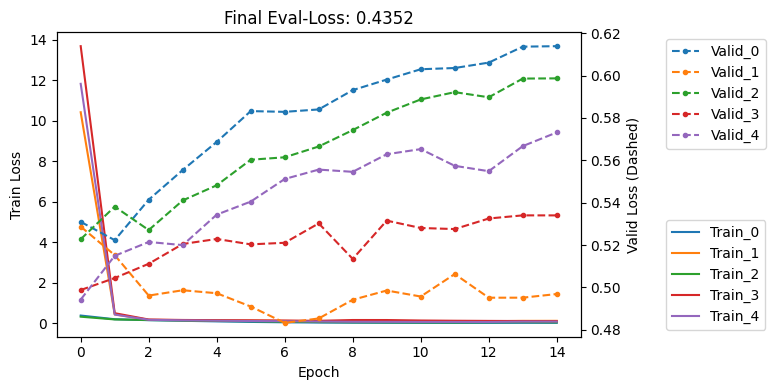

In [18]:
# --------------------------------------------------------------
# Training Loop Starts Here
# --------------------------------------------------------------
loader_kwargs = {
    "batch_size": config.batch_size,
    "num_workers": config.num_workers,
    "pin_memory": True,
    "shuffle": False,
    'collate_fn': collate_fn
}

prediction_columns = [f"pred_{i}" for i in range(config.n_classes)]
    
for fold_id in range(0, config.n_splits):
    tik = time()
    
    wandb_init(project_name=config.model_name, run_name=f"fold_{fold_id}", config=config)
    
    train_df = df_audio_meta[df_audio_meta['fold'] != fold_id].copy().reset_index(drop=True)
    valid_df = df_audio_meta[df_audio_meta['fold'] == fold_id].copy().reset_index(drop=True)
    
    train_folds = BirdSongDataset(train_df, config)
    valid_folds = BirdSongDataset(valid_df, config)
    
    train_loader = DataLoader(train_folds, **loader_kwargs)
    valid_loader = DataLoader(valid_folds, **loader_kwargs)
        
    model = BirdAudioMAE(config.backbone_name, config.n_classes, device=DEVICE, n_mlp_layers=1, activation='silu')
    
    trainer = Trainer(model, loss_fn, eval_fn, logger, config, is_higher_better=True)
    
    best_weights, best_preds, loss_records = trainer.train( 
        train_loader, 
        valid_loader, 
        print_epoch_freq=config.print_epoch_freq,
        from_checkpoint=None,
        use_tqdm=True
        )
    
    loss_history.append(loss_records)
    
    df_valid = pd.DataFrame({'species_id': valid_df['species_id'], 'fold': fold})
    _df = pd.DataFrame(best_preds, columns=prediction_columns)
    df_valid = pd.concat([df_valid, _df], axis=1)
    
    oof = pd.concat([oof, df_valid], axis=0).reset_index(drop=True)
    
    save_model_name = f"{config.model_name}_fold_{fold_id}"
    torch.save(best_weights, f"{config.log_dir}/{save_model_name}.pth")

    del train_folds, valid_folds, train_loader, valid_loader
    torch.cuda.empty_cache()
    gc.collect()
    
    valid_loss_fold = eval_fn(
        torch.tensor(oof[prediction_columns].values),
        torch.tensor(oof['species_id'].values)
    )
    logger.info(f"Fold {fold_id} | Time: {(time() - tik)/60:.2f}min | Overall Evaluation Loss: {valid_loss_fold:.4f}")
    
    # Save the oof predictions
    oof.to_csv(f"{config.log_dir}/{config.model_name}_oof.csv", index=False)
    
    wandb.finish()
        
# Summarize the final results
valid_loss = eval_fn(
    torch.tensor(oof[prediction_columns].values),
    torch.tensor(oof['species_id'].values)
)

plot_loss_record(loss_history, valid_loss, start_at=0, save_to=os.path.join(config.log_dir, f"{config.model_name}_loss.jpg"))

In [19]:
oof.head()

,species_id,fold,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,...,pred_718,pred_719,pred_720,pred_721,pred_722,pred_723,pred_724,pred_725,pred_726,pred_727
0,329,4,-1.206560,1.384848,-2.634542,-3.487893,-3.701632,-2.969731,-2.801717,-1.239782,...,-1.714339,-2.108958,-3.331261,-2.054324,-0.395864,-0.989750,-0.956848,-2.539559,-1.494200,-3.561635
1,329,4,-3.104391,1.992842,-3.478614,-5.228971,-2.921334,-1.500246,-5.123263,-1.685007,...,-1.918088,-3.052327,-3.896048,1.398749,-0.089792,-1.978370,-1.522866,-2.507293,-3.240541,-3.514860
2,94,4,-0.316838,-1.759019,-1.522814,-0.135115,-3.298048,-1.855434,-1.220261,-2.059662,...,-4.256361,-1.609519,-3.678644,-4.052227,-3.601637,-1.733025,-1.126034,-1.136884,-3.204915,0.574395
3,262,4,-2.858818,-2.237144,-1.291077,-2.903850,-4.240028,-1.507519,-2.208751,-4.723540,...,-5.563849,3.294152,-3.199532,-1.144527,-4.261771,-3.040057,-1.582602,-1.945570,-5.157303,-4.486679
4,262,4,-1.622524,-0.894221,-0.531596,-2.791069,-3.014908,-2.718237,-1.042463,-3.374171,...,-3.857933,0.892866,-3.310192,-1.818043,-3.327792,-3.680323,-1.183315,-2.137847,-4.231442,-1.191892


In [20]:
# parse training log
import re 

log_file = f"{config.log_dir}/{config.model_name}_training.log"

with open(log_file, 'r') as f:
    lines = f.readlines()
    
epoch_records = []
epoch_pattern = re.compile(r"Epoch (\d+) - Train Loss: (\d+\.\d+) - Valid Loss: (\d+\.\d+) - Elapsed Time: (\d+\.\d+)s")

for line in lines:
    
    try:
        epoch, train_loss, valid_loss, elapsed = epoch_pattern.findall(line)[0]
        epoch_records.append({
            "epoch": int(epoch),
            "train_loss": float(train_loss),
            "valid_loss": float(valid_loss),
            "elapsed": float(elapsed)
        })
        
    except:
        pass
    
df_epoch_records = pd.DataFrame(epoch_records)

df_epoch_records['fold_id'] = df_epoch_records.index // 5

df_epoch_records

,epoch,train_loss,valid_loss,elapsed,fold_id
0,1,0.3279,0.5271,208.04,0
1,2,0.1913,0.5161,194.26,0
2,3,0.1555,0.5228,193.34,0
3,4,0.1288,0.5381,192.61,0
4,5,0.0989,0.5543,192.94,0
...,...,...,...,...,...
145,11,0.0677,0.5653,97.77,29
146,12,0.0674,0.5574,115.29,29
147,13,0.0661,0.5549,186.95,29
148,14,0.0822,0.5667,181.95,29


In [21]:
# analyze oof predictions
df_oof = pd.read_csv(f"{config.log_dir}/{config.model_name}_oof.csv")
df_oof['species_id'] = df_oof['species_id'].astype(int)

species_category = pd.cut(
    df_oof['species_id'].value_counts(), 
    bins=[0, 50, 120], 
    labels=['0-50', '50-120']
    ).to_frame()

species_category['count']

df_oof['species_category'] = df_oof['species_id'].map({i: c for i, c in enumerate(species_category['count'])})

prediction_columns = [f"pred_{i}" for i in range(config.n_classes)]

display(df_oof.head())

# eval_fn = ROC_AUC_Score(config, average='macro', multi_class='ovo')

# # caculate the overall evaluation loss
# eval_loss = eval_fn(
#     torch.tensor(df_oof[prediction_columns].values),
#     torch.tensor(df_oof['species_id'].values)
# )

# print(f"Overall Evaluation Loss: {eval_loss:.4f}")

,species_id,fold,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,...,pred_719,pred_720,pred_721,pred_722,pred_723,pred_724,pred_725,pred_726,pred_727,species_category
0,329,4,-1.206560,1.384848,-2.634542,-3.487893,-3.701632,-2.969731,-2.801717,-1.239783,...,-2.108957,-3.331261,-2.054324,-0.395864,-0.989750,-0.956848,-2.539559,-1.494200,-3.561635,0-50
1,329,4,-3.104391,1.992842,-3.478614,-5.228970,-2.921334,-1.500246,-5.123263,-1.685007,...,-3.052327,-3.896048,1.398749,-0.089792,-1.978370,-1.522865,-2.507293,-3.240541,-3.514860,0-50
2,94,4,-0.316838,-1.759019,-1.522814,-0.135115,-3.298048,-1.855434,-1.220261,-2.059662,...,-1.609519,-3.678644,-4.052227,-3.601637,-1.733025,-1.126033,-1.136884,-3.204915,0.574395,0-50
3,262,4,-2.858818,-2.237144,-1.291077,-2.903850,-4.240028,-1.507519,-2.208751,-4.723540,...,3.294151,-3.199532,-1.144527,-4.261771,-3.040057,-1.582601,-1.945570,-5.157303,-4.486679,0-50
4,262,4,-1.622524,-0.894221,-0.531596,-2.791069,-3.014908,-2.718237,-1.042463,-3.374170,...,0.892866,-3.310192,-1.818043,-3.327792,-3.680323,-1.183315,-2.137847,-4.231442,-1.191892,0-50


In [22]:
len(df_oof['species_id'].unique())

728

In [23]:
# make cm plots
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, labels, save_to=None):
    
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm = cm / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    # plt.xticks([])
    # plt.yticks([])
    plt.title("Normalized Confusion Matrix")
    
    if save_to:
        plt.savefig(save_to)
    
    plt.show()



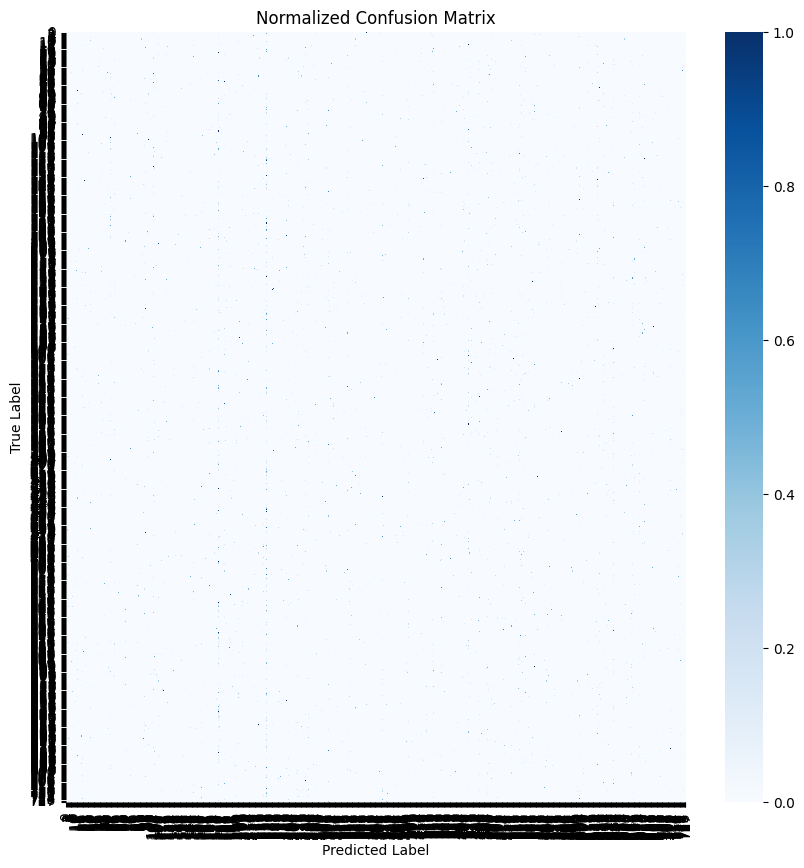

In [24]:
# plot confusion matrix
y_true = df_oof['species_id'].values
y_pred = df_oof[prediction_columns].values.argmax(axis=1)

labels = df_oof['species_id'].unique()
labels.sort()

plot_confusion_matrix(
    y_true, y_pred, 
    labels=labels,
    save_to=os.path.join(config.log_dir, f"{config.model_name}_cm.jpg")
    )

/tmp/ipykernel_53496/3341622484.py:8: RuntimeWarning: invalid value encountered in divide
  cm = cm / cm.sum(axis=1)[:, np.newaxis]


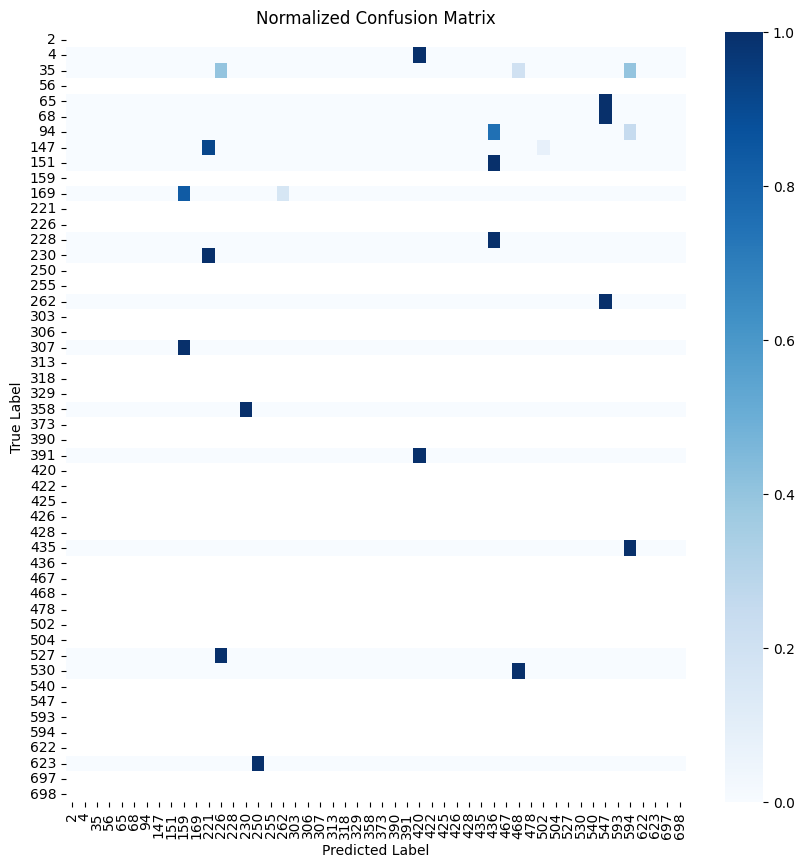

In [25]:
labels = df_oof['species_id'].unique()[:50]
labels.sort()

tmp = df_oof[df_oof['species_id'].isin(labels)].copy()
# plot confusion matrix
y_true = tmp['species_id'].values
y_pred = tmp[prediction_columns].values.argmax(axis=1)

plot_confusion_matrix(y_true, y_pred, labels=labels, save_to=None)

In [26]:
# calc F1, Precision, Recall, mAP 
from sklearn.metrics import f1_score, precision_score, recall_score 
import warnings

warnings.filterwarnings("ignore")

print(species_category['count'].unique())

for category_id in ['0-50', '50-120']:
    tmp = df_oof[df_oof['species_category'] == category_id].copy().reset_index(drop=True)

    y_true = tmp['species_id'].values
    y_pred = tmp[prediction_columns].values.argmax(axis=1)

    f1 = f1_score(y_true, y_pred, average='macro')
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')

    print(f"Category: {category_id} | N_samples: {len(tmp)} | N_classes: {tmp['species_id'].nunique()} | F1: {f1} | Precision: {precision} | Recall: {recall:.4f}")

    # labels = tmp['species_id'].unique()
    # cm = confusion_matrix(y_true, y_pred, labels=labels, normalize='pred')
    
    # plt.figure(figsize=(10, 10))
    # sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=labels, yticklabels=labels)
    # plt.xlabel("Predicted Label")
    # plt.ylabel("True Label")
    # plt.title("Normalized Confusion Matrix | Category: " + category_id)
    
    # break

['50-120', '0-50']
Categories (2, object): ['0-50' < '50-120']
Category: 0-50 | N_samples: 10714 | N_classes: 691 | F1: 0.0011015831741154765 | Precision: 0.002420466739157218 | Recall: 0.0022
Category: 50-120 | N_samples: 457 | N_classes: 37 | F1: 0.0 | Precision: 0.0 | Recall: 0.0000


NameError: name 'eval_loss' is not defined

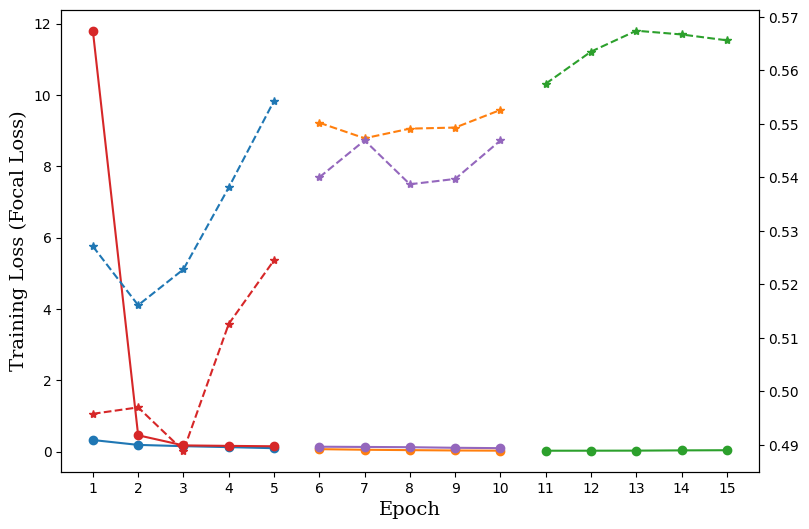

In [27]:
# plot training progress
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

ax_right = ax.twinx()

for fold_id in range(config.n_splits):
    df_fold = df_epoch_records[df_epoch_records['fold_id'] == fold_id]
    ax.plot(df_fold['epoch'], df_fold['train_loss'], marker='o', label=f"Train_Fold_{fold_id}")
    ax_right.plot(df_fold['epoch'], df_fold['valid_loss'], linestyle="--", marker='*', label=f"Valid_Fold_{fold_id}")

ax.set_xticks(np.arange(0, config.epochs, 1)+1)
ax.set_xlabel("Epoch", fontsize=14, fontfamily='serif')
ax.set_ylabel("Training Loss (Focal Loss)", fontsize=14, fontfamily='serif')
ax.set_title(f"Training Progress | Overall ROCAUC: {eval_loss:.3f}", fontsize=18, fontfamily='serif')
ax.legend(loc='upper left')

ax_right.set_ylabel("Validation Loss (ROCAUC)", fontsize=14, fontfamily='serif')
ax_right.legend(loc='lower left')

ax.set_facecolor('#f3ede2')
fig.set_facecolor('#f3ede2')

fig.tight_layout()
plt.show()